### Copyright 2023 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Instructions

* We recommend executing the notebook with a T4 GPU kernel.
* Use the **Table of contents** tab in the left pane to navigate between sections in the notebook.
* Use the **Files** tab in the left pane to download the figures output by the notebook.
* Always execute all cells in the **Setup** section before anything else.
* The notebook is divided into two independent main sections:
  * The **Toy experiments** section contains the code for reproducing the 1D toy experiments.
  * The **LM1B experiments** section contains the code for reproducing the One Billion Words Benchmark experiments.

# Setup

In [0]:
%%capture
!pip install ml_collections tensorflow-text

## Imports

In [0]:
import contextlib
import dataclasses
import functools
import hashlib
import itertools
from typing import Any, Callable, Sequence
import warnings

In [0]:
from etils import epath
import flax
from flax import struct
import flax.linen as nn
from flax.training import checkpoints
from flax.training import common_utils
from flax.training import train_state as train_state_lib
import jax
from jax import lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from tensorflow_probability.substrates import jax as tfp
import tensorflow_text as tftxt
import tqdm.notebook

In [0]:
tfd = tfp.distributions

ConfigDict = ml_collections.ConfigDict
placeholder = ml_collections.config_dict.placeholder
TensorShape = tfp.internal.tensorshape_util.tf.TensorShape
TrainState = train_state_lib.TrainState
VariableDict = flax.core.scope.VariableDict

## Utility functions

In [0]:
def fold_in_str(key: jax.Array, string: str) -> jax.Array:
  """Returns a PRNG key derived from an initial PRNG key and a string input.

  Args:
    key: The initial PRNG key.
    string: The string input (e.g., 'pretrain', 'query', etc.).

  Returns:
    A PRNG key derived from the initial PRNG key and the string input.
  """
  return jax.random.fold_in(
      key, int(hashlib.md5(string.encode()).hexdigest()[:8], base=16)
  )

In [0]:
def add_parameter_noise(key: jax.Array, params: VariableDict, scale: float):
  """Adds random normal noise to model parameters.

  Args:
    key: The PRNG key.
    params: The model parameters.
    scale: The scale of the normal distribution used to sample noise.

  Returns:
    The parameters with random normal noise added.
  """
  return flax.traverse_util.path_aware_map(
      lambda p, v: v
      + scale
      * jax.random.normal(
          key=fold_in_str(key, '/'.join(p)),
          shape=v.shape,
          dtype=v.dtype,
      ),
      params,
  )

In [0]:
@contextlib.contextmanager
def custom_theme(palette: str = 'colorblind', font_scale: float = 1.0):
  """Defines a custom theme for plotting as a context manager.

  Args:
    palette: The color palette to use.
    font_scale: The font scale.
  """
  try:
    sns.set_theme(
        context='talk',
        palette=palette,
        style='white',
        font_scale=font_scale,
        rc={
            'lines.linewidth': 3.5,
            'axes.spines.right': False,
            'axes.spines.top': False,
        },
    )
    yield
  finally:
    sns.reset_defaults()

# Toy experiments

## Utility functions

In [0]:
def mlp_energy_function_constructor(
    layer_width: int,
    num_layers: int,
    activation_fn: Callable[[jnp.ndarray], jnp.ndarray],
) -> Callable[[], nn.Module]:
  """Creates an MLP energy function constructor.

  Args:
    layer_width: Number of hidden units in each layer.
    num_layers: Number of hidden layers.
    activation_fn: Activation function.

  Returns:
    A callable which takes no argument as input and returns an energy function
      module.
  """

  def constructor() -> nn.Module:
    layers = []
    for _ in range(num_layers):
      layers.extend([nn.Dense(layer_width), activation_fn])
    layers.append(nn.Dense(1))
    return nn.Sequential(layers)

  return constructor

## Flax modules

In [0]:
class UnivariateEBM(nn.Module):
  """An energy-based model for a univariate distribution with finite support.

  Attributes:
    energy_function_constructor: A callable taking no argument as input that
      constructs the energy function module.
    discretized_support: A 1D tensor representing the (discretized) support.
  """

  energy_function_constructor: Callable[[], nn.Module] = dataclasses.field()
  discretized_support: jnp.ndarray = dataclasses.field()

  def setup(self):
    self.energy_function = self.energy_function_constructor()

  def preference_logits(
      self, x_a: jnp.ndarray, x_b: jnp.ndarray
  ) -> jnp.ndarray:
    return self(x_a) - self(x_b)

  def __call__(self, x: jnp.ndarray, normalized: bool = False) -> jnp.ndarray:
    """Returns the EBM's log-density for `x`.

    Args:
      x: The inputs.
      normalized: If False, returns the negative energy. If True, returns the
        negative energy plus the log-partition function.

    Returns:
      The log-density for `x`.
    """
    neg_energy = -self.energy_function(x[:, None])
    if normalized:
      support_neg_energies = -self.energy_function(
          self.discretized_support[:, None]
      ).reshape(-1)
      width = self.discretized_support[1] - self.discretized_support[0]
      neg_energy -= jax.scipy.special.logsumexp(
          jnp.log(0.5)
          + jax.scipy.special.logsumexp(
              jnp.stack([support_neg_energies[:-1], support_neg_energies[1:]]),
              axis=0,
          )
          + jnp.log(width)
      )
    return neg_energy.reshape(neg_energy.shape[:-1])

In [0]:
class CategoricalStatefulUnivariateEBM(nn.Module):
  r"""A hidden-variable EBM for a univariate distribution with finite support.

  The model marginalizes over a categorical hidden variable `h` as

      p(x) = \sum_i w_i exp(-E_i(x)).

  Attributes:
    energy_function_constructor: A tuple of callables taking no argument as
      input and construct the energy function modules for each mixture
      component.
    discretized_support: A 1D tensor representing the (discretized) support.
  """

  energy_function_constructors: tuple[Callable[[], nn.Module], ...] = (
      dataclasses.field()
  )
  discretized_support: jnp.ndarray = dataclasses.field()

  def setup(self):
    for i, energy_function_constructor in enumerate(
        self.energy_function_constructors
    ):
      setattr(self, f'energy_function_{i}', energy_function_constructor())
    self.prior_logits = self.param(
        'prior_logits',
        nn.initializers.zeros_init(),
        (len(self.energy_function_constructors),),
    )

  def preference_logits(
      self, x_a: jnp.ndarray, x_b: jnp.ndarray
  ) -> jnp.ndarray:
    x_a, x_b = x_a[:, None], x_b[:, None]
    logits = []
    for i in range(len(self.prior_logits)):
      energy_function = getattr(self, f'energy_function_{i}')
      # NOTE: the unnormalized log-density is the negative energy, therefore
      # the logits are the difference of energies between x_b and x_a (and not
      # the other way around).
      logits.append(energy_function(x_b) - energy_function(x_a))
    logits = jnp.stack(logits)
    logits = jax.scipy.special.logsumexp(
        self.prior_logits[:, None, None] - jax.nn.softplus(-logits),
        axis=0,
    ) - jax.scipy.special.logsumexp(
        self.prior_logits[:, None, None] - jax.nn.softplus(logits),
        axis=0,
    )
    return logits.reshape(logits.shape[:-1])

  def __call__(self, x: jnp.ndarray, normalized: bool = True) -> jnp.ndarray:
    """Returns the EBM's log-density for `x`.

    Args:
      x: The inputs.
      normalized: If False, returns the negative energy. If True, returns the
        negative energy plus the log-partition function.

    Returns:
      The log-density for `x`.
    """
    if not normalized:
      raise NotImplementedError

    x = x[:, None]

    # The model is defined as
    #
    #     p(x) = \sum_i w_i / Z_i * exp(-E_i(x)),
    #
    # which means that the log-density is
    #
    #     log p(x) = log \sum_i exp(-E_i(x) + log w_i - log Z_i).
    log_densities = []
    for i in range(len(self.prior_logits)):
      energy_function = getattr(self, f'energy_function_{i}')
      neg_energy = -energy_function(x)
      support_neg_energies = -energy_function(
          self.discretized_support[:, None]
      ).reshape(-1)
      width = self.discretized_support[1] - self.discretized_support[0]
      partition_function = jax.scipy.special.logsumexp(
          jnp.log(0.5)
          + jax.scipy.special.logsumexp(
              jnp.stack([support_neg_energies[:-1], support_neg_energies[1:]]),
              axis=0,
          )
          + jnp.log(width)
      )
      log_densities.append(neg_energy - partition_function)
    log_density = jax.scipy.special.logsumexp(
        jnp.stack(log_densities)
        + self.prior_logits[:, None, None]
        - jax.scipy.special.logsumexp(self.prior_logits),
        axis=0,
    )
    return log_density.reshape(log_density.shape[:-1])

## Configuration

In [0]:
_mlp_kwargs = {'num_layers': 4, 'layer_width': 64, 'activation_fn': nn.tanh}
_random_config = ConfigDict(
    {'key': jax.random.PRNGKey(42), 'low': -10.0, 'high': 10.0}
)

TOY_CONFIG = ConfigDict({
    'random': _random_config,
    'models': ConfigDict({
        'single_annotator': ConfigDict({
            'model': UnivariateEBM(
                energy_function_constructor=mlp_energy_function_constructor(
                    **_mlp_kwargs
                ),
                discretized_support=jnp.linspace(
                    # 2**16 results in small enough bins to compute the
                    # partition function.
                    start=_random_config.low,
                    stop=_random_config.high,
                    num=2**16,
                ),
            ),
        }),
        'multi_annotator': ConfigDict(
            {
                'model': CategoricalStatefulUnivariateEBM(
                    energy_function_constructors=[
                        mlp_energy_function_constructor(**_mlp_kwargs),
                        mlp_energy_function_constructor(**_mlp_kwargs),
                    ],
                    discretized_support=jnp.linspace(
                        # 2**16 -> small enough bins to compute the partition
                        # function.
                        start=_random_config.low,
                        stop=_random_config.high,
                        num=2**16,
                    ),
                )
            }
        ),
    }),
    'pretraining': ConfigDict({
        'learning_rate': 1e-3,
        'num_steps': 4_096,
        'target_distribution': tfd.TruncatedNormal(
            loc=0.0, scale=5.0, low=_random_config.low, high=_random_config.high
        ),
        'state': placeholder(TrainState, required=True),
    }),
    'training': ConfigDict({
        'data': ConfigDict({
            'x_a': placeholder(jnp.ndarray, required=True),
            'x_b': placeholder(jnp.ndarray, required=True),
            'y_luce': placeholder(jnp.ndarray, required=True),
            'y_dpo_beta_4': placeholder(jnp.ndarray, required=True),
            'y_multi_luce': placeholder(jnp.ndarray, required=True),
        }),
        'learning_rate': 1e-4,
        'num_steps': 8_192,
        'num_observation_pairs': 2**15,
        'implicit_preference_distribution': tfd.Mixture(
            cat=tfd.Categorical(probs=[0.4, 0.6]),
            components=[
                tfd.TruncatedNormal(
                    loc=-2.5,
                    scale=0.25,
                    low=_random_config.low,
                    high=_random_config.high,
                ),
                tfd.TruncatedNormal(
                    loc=2.5,
                    scale=1.0,
                    low=_random_config.low,
                    high=_random_config.high,
                ),
            ],
        ),
        'slic': ConfigDict({
            'regularizer_batch_size': 8_192,
        }),
    }),
})

## Model pretraining

In [0]:
def make_ebm_pretrain_step_fn(
    ebm: nn.Module,
    target_distribution: tfd.Distribution,
    axis_name: str | None = None,
) -> Callable[[TrainState, jnp.ndarray], TrainState]:
  """Creates a pretraining step function for an energy-based model (EBM).

  The function performs one gradient step on the squared difference in
  log-likelihoods between the EBM and a target distribution. It accepts the
  following as input:

  * state: The model state.
  * x: The batch of inputs used to compute the regression loss.

  Args:
    ebm: The flax module representing the EBM.
    target_distribution: The distribution towards which to regress the EBM.
    axis_name: The name of the axis over which to apply the `pmean` operation on
      the gradients. If None, no `pmean` will be applied.

  Returns:
    The EBM pretraining step function.
  """

  def loss(params: VariableDict, x: jnp.ndarray) -> jnp.ndarray:
    target_log_prob = target_distribution.log_prob(x)
    return jnp.mean((target_log_prob - ebm.apply({'params': params}, x)) ** 2)

  def pretrain_step(state: TrainState, x: jnp.ndarray) -> TrainState:
    grads = jax.grad(loss)(state.params, x)
    if axis_name:
      grads = jax.lax.pmean(grads, axis_name=axis_name)
    return state.apply_gradients(grads=grads)

  return pretrain_step

In [0]:
# PRNG
key = fold_in_str(TOY_CONFIG.random.key, 'pretrain')

# Optimizer
learning_rate = optax.cosine_decay_schedule(
    init_value=TOY_CONFIG.pretraining.learning_rate,
    decay_steps=TOY_CONFIG.pretraining.num_steps,
    alpha=0.0,
)
optimizer = optax.adam(learning_rate=learning_rate)

# Model
ebm = TOY_CONFIG.models.single_annotator.model
support = common_utils.shard(ebm.discretized_support)
initial_params = ebm.init(key, jnp.zeros((1,)))['params']
pretrain_state = flax.jax_utils.replicate(
    TrainState.create(apply_fn=ebm.apply, params=initial_params, tx=optimizer)
)

# Target distribution
target_distribution = TOY_CONFIG.pretraining.target_distribution

# Optimization loop
print('Pretraining the EBM...')

pretrain_step = jax.pmap(
    make_ebm_pretrain_step_fn(ebm, target_distribution, axis_name='batch'),
    axis_name='batch',
)

for _ in tqdm.notebook.tqdm(range(TOY_CONFIG.pretraining.num_steps)):
  pretrain_state = pretrain_step(pretrain_state, support)

TOY_CONFIG.pretraining.state = flax.jax_utils.unreplicate(pretrain_state)

## Annotator preference acquisition

### Higher-order functions for sampling from the proposal and annotator preference distributions

In [0]:
def make_ebm_sampling_fn(
    ebm: nn.Module, num_samples: int
) -> Callable[[jax.Array, TrainState], jnp.ndarray]:
  """Creates a sampling function for an energy-based model (EBM).

  The function accepts the following as input:

  * key: The PRNG key.
  * state: The EBM's state.

  Args:
    ebm: The flax module representing the EBM.
    num_samples: The number of samples to draw.

  Returns:
    The EBM sampling function.
  """

  def sampling_fn(
      key: jax.Array, state: TrainState
  ) -> tuple[jnp.ndarray, jnp.ndarray]:
    a = ebm.discretized_support
    p = jnp.exp(
        state.apply_fn(
            {'params': state.params}, a[:, None], normalized=True
        ).reshape(-1)
    )
    return jax.random.choice(key, a=a, shape=(num_samples,), p=p, replace=True)

  return sampling_fn

In [0]:
def make_luce_preference_sampling_fn(
    distribution: tfd.Distribution,
) -> Callable[[jax.Array, jnp.ndarray, jnp.ndarray], jnp.ndarray]:
  """Creates a function to sample pairwise preferences via the Luce choice rule:

      p(y; x_a, x_b) = σ(log p(x_a) - log p(x_b))

  The function accepts the following as input:

  * key: The PRNG key.
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.

  Args:
    distribution: The implicit preference distribution.

  Returns:
    The Luce choice rule preference sampling function.
  """

  def luce_preference_sampling_fn(
      key: jax.Array, x_a: jnp.ndarray, x_b: jnp.ndarray
  ) -> jnp.ndarray:
    logits = distribution.log_prob(x_a) - distribution.log_prob(x_b)
    return tfd.Bernoulli(logits=logits).sample(seed=key)

  return luce_preference_sampling_fn

In [0]:
def make_dpo_preference_sampling_fn(
    distribution: tfd.Distribution,
    ebm: nn.Module,
    original_params: VariableDict,
) -> Callable[[jax.Array, jnp.ndarray, jnp.ndarray, float], jnp.ndarray]:
  r"""Creates a function to sample pairwise preferences via the DPO rule:

      p(y; x_a, x_b) = σ(
          beta * ((log p(x_a) - log π_pre(x_a)) - (log p(x_b) - log π_pre(x_b)))
      )

  The function accepts the following as input:

  * key: The PRNG key.
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.
  * beta: The KL-control regularization term.

  Args:
    distribution: The implicit preference distribution.
    ebm: The flax module representing the EBM used as π_pre(x).
    original_params: The parameters of the EBM for π_pre(x).

  Returns:
    The DPO preference sampling function.
  """

  def dpo_preference_sampling_fn(
      key: jax.Array, x_a: jnp.ndarray, x_b: jnp.ndarray, beta: float
  ) -> jnp.ndarray:
    logits = distribution.log_prob(x_a) - distribution.log_prob(x_b)
    method = ebm.preference_logits
    logits = beta * (
        logits - ebm.apply({'params': original_params}, x_a, x_b, method=method)
    )
    return tfd.Bernoulli(logits=logits).sample(seed=key)

  return dpo_preference_sampling_fn

In [0]:
def make_multi_annotator_preference_sampling_fn(
    distribution: tfd.Mixture,
) -> Callable[[jax.Array, jnp.ndarray, jnp.ndarray], jnp.ndarray]:
  r"""Creates a function to sample multi-annotator pairwise preferences.

  Each annotator independently follows the Luce choice rule such that

      p(y; x_a, x_b) = \sum_i w_i * σ(log p_i(x_a) - log p_i(x_b))

  The function accepts the following as input:

  * key: The PRNG key.
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.

  Args:
    distribution: The implicit preference distribution. It is expected to be a
      `tfd.Mixture` instance in which each of the mixture components represents
      a given annotator's implicit preference distribution.

  Returns:
    The multi-annotator preference sampling function.
  """

  def multi_annotator_preference_sampling_fn(
      key: jax.Array,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
  ):
    conditional_r_a = jnp.stack(
        [component.log_prob(x_a) for component in distribution.components]
    )
    conditional_r_b = jnp.stack(
        [component.log_prob(x_b) for component in distribution.components]
    )
    p = (
        distribution.cat.probs[:, None]
        * nn.sigmoid(conditional_r_a - conditional_r_b)
    ).sum(axis=0)
    logits = jnp.log(p) - jnp.log(1 - p)
    return tfd.Bernoulli(logits=logits).sample(seed=key)

  return multi_annotator_preference_sampling_fn

### Sampling

In [0]:
# PRNG
key = TOY_CONFIG.random.key
proposal_key = fold_in_str(key, 'proposal')
luce_key = fold_in_str(key, 'query_luce')
dpo_key = fold_in_str(key, 'query_dpo')
multi_annotator_key = fold_in_str(key, 'query_multi_luce')

# Implicit preference distribution
ebm = TOY_CONFIG.models.single_annotator.model
pretrain_state = TOY_CONFIG.pretraining.state
distribution = TOY_CONFIG.training.implicit_preference_distribution

# Proposal and preference sampling
sampling_fn = jax.jit(
    make_ebm_sampling_fn(ebm, 2 * TOY_CONFIG.training.num_observation_pairs)
)
x_a, x_b = jnp.split(sampling_fn(proposal_key, pretrain_state), 2)
TOY_CONFIG.training.data.x_a = x_a
TOY_CONFIG.training.data.x_b = x_b

#
#     p(y; x_a, x_b) = σ(log p(x_a) - log p(x_b))
#
TOY_CONFIG.training.data.y_luce = jax.jit(
    make_luce_preference_sampling_fn(distribution)
)(luce_key, x_a, x_b)

#     p(y; x_a, x_b) = σ(
#         4 * ((log p(x_a) - log π_pre(x_a)) - (log p(x_b) - log π_pre(x_b)))
#     )
TOY_CONFIG.training.data.y_dpo_beta_4 = jax.jit(
    make_dpo_preference_sampling_fn(distribution, ebm, pretrain_state.params)
)(dpo_key, x_a, x_b, beta=4.0)

#
#     p(y; x_a, x_b) = \sum_i w_i * σ(log p_i(x_a) - log p_i(x_b))
#
TOY_CONFIG.training.data.y_multi_luce = jax.jit(
    make_multi_annotator_preference_sampling_fn(distribution)
)(multi_annotator_key, x_a, x_b)

## Reward training

In [0]:
# @title Higher-order function for the reward training step
def make_reward_train_step_fn(
    ebm: nn.Module, axis_name: str | None = None
) -> Callable[[TrainState, jnp.ndarray, jnp.ndarray, jnp.ndarray], TrainState]:
  r"""Creates a training step function for the learned reward.

  The function performs one gradient step on the binary classification problem
  for the comparison outcome between x_a and x_b using the learned reward r_φ(x)
  and the Bradley-Terry model to make a prediction

      p_φ(y; x_a, x_b) = σ(r_φ(x_a) - r_φ(x_b))

  The training step function accepts the following as input:

  * state: The reward state.
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.
  * y: The batch of comparison outcomes (1 means x_a is preferred and 0 means
      x_b is preferred).

  Args:
    ebm: The flax module representing the EBM.
    axis_name: The name of the axis over which to apply the `pmean` operation on
      the gradients. If None, no `pmean` will be applied.

  Returns:
    The reward training step function.
  """

  def loss(
      params: VariableDict, x_a: jnp.ndarray, x_b: jnp.ndarray, y: jnp.ndarray
  ) -> jnp.ndarray:
    logits = ebm.apply(
        {'params': params}, x_a, x_b, method=ebm.preference_logits
    )
    return -tfd.Bernoulli(logits=logits).log_prob(y).mean()

  def reward_train_step_fn(
      state: TrainState, x_a: jnp.ndarray, x_b: jnp.ndarray, y: jnp.ndarray
  ) -> TrainState:
    grads = jax.grad(loss)(state.params, x_a, x_b, y)
    if axis_name:
      grads = jax.lax.pmean(grads, axis_name=axis_name)
    return state.apply_gradients(grads=grads)

  return reward_train_step_fn

In [0]:
# PRNG
key = fold_in_str(TOY_CONFIG.random.key, 'reward_init')

# Optimizer
learning_rate = optax.cosine_decay_schedule(
    init_value=TOY_CONFIG.training.learning_rate,
    decay_steps=TOY_CONFIG.training.num_steps,
    alpha=0.0,
)
optimizer = optax.adam(learning_rate=learning_rate)

# Model
model = TOY_CONFIG.models.single_annotator.model
initial_params = model.init(key, jnp.ones((1,)))['params']
reward_state = flax.jax_utils.replicate(
    TrainState.create(apply_fn=model.apply, params=initial_params, tx=optimizer)
)

# Inputs
x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
y_luce = common_utils.shard(TOY_CONFIG.training.data.y_luce)

# Optimization loop
print('Training the reward...')

reward_train_step = jax.pmap(
    make_reward_train_step_fn(model, axis_name='batch'), axis_name='batch'
)

for _ in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
  reward_state = reward_train_step(reward_state, x_a, x_b, y_luce)

reward_state = flax.jax_utils.unreplicate(reward_state)

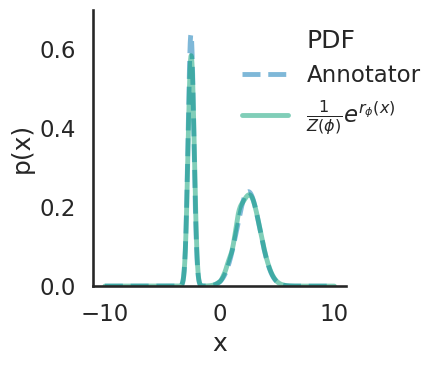

In [0]:
# @title `reward-training.pdf`
model = TOY_CONFIG.models.single_annotator.model

with custom_theme(palette=sns.color_palette('colorblind')[::2]):
  _ = (
      sns.FacetGrid(
          data=pd.concat([
              pd.DataFrame({
                  'p(x)': (
                      TOY_CONFIG.training.implicit_preference_distribution.prob(
                          model.discretized_support
                      )
                  ),
                  'PDF': 'Annotator',
                  'x': model.discretized_support,
              }),
              pd.DataFrame({
                  'p(x)': jnp.exp(
                      TOY_CONFIG.models.single_annotator.model.apply(
                          {'params': reward_state.params},
                          model.discretized_support,
                          normalized=True,
                      )
                  ),
                  'PDF': r'$\frac{1}{Z(\phi)}e^{r_\phi(x)}$',
                  'x': model.discretized_support,
              }),
          ]),
          hue='PDF',
          hue_order=('Annotator', r'$\frac{1}{Z(\phi)}e^{r_\phi(x)}$'),
          hue_kws={'linestyle': ['dashed', 'solid'], 'alpha': [0.5] * 2},
          sharey=False,
          height=4,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(xticks=[-10, 0, 10], ylim=(0.0, 0.7))
      .add_legend(loc='center left', bbox_to_anchor=(0.4, 0.75))
      .tight_layout()
      .savefig('reward-training.pdf')
  )
  plt.show()

**Reward training**: Training a reward model on comparison outcomes stemming from a synthetic implicit preference distribution (dashed blue) recovers the implicit distribution (solid green).

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

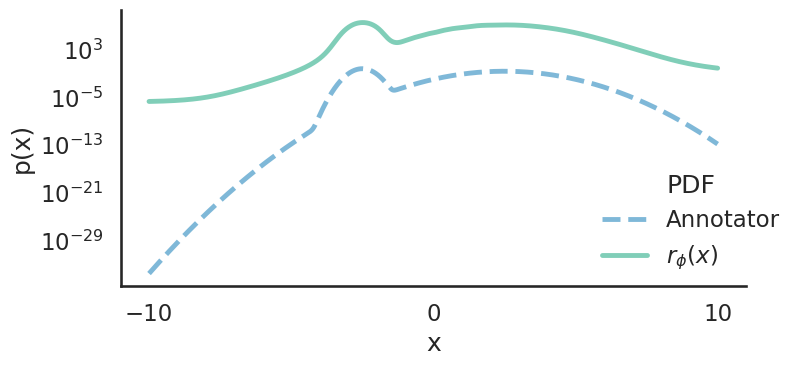

In [0]:
# @title `reward-training-log.pdf`
model = TOY_CONFIG.models.single_annotator.model

with custom_theme(palette=sns.color_palette('colorblind')[::2]):
  _ = (
      sns.FacetGrid(
          data=pd.concat([
              pd.DataFrame({
                  'p(x)': (
                      TOY_CONFIG.training.implicit_preference_distribution.prob(
                          model.discretized_support
                      )
                  ),
                  'PDF': 'Annotator',
                  'x': model.discretized_support,
              }),
              pd.DataFrame({
                  'p(x)': jnp.exp(
                      model.apply(
                          {'params': reward_state.params},
                          model.discretized_support,
                          normalized=False,
                      )
                  ),
                  'PDF': r'$r_\phi(x)$',
                  'x': model.discretized_support,
              }),
          ]),
          hue='PDF',
          hue_order=('Annotator', r'$r_\phi(x)$'),
          hue_kws={'linestyle': ['dashed', 'solid'], 'alpha': [0.5] * 2},
          sharey=False,
          height=4,
          aspect=2,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(yscale='log', xticks=[-10, 0, 10])
      .add_legend(loc='center left', bbox_to_anchor=(0.6, 0.4))
      .tight_layout()
      .savefig('reward-training-log.pdf')
  )
  plt.show()

**Reward training (log scale)**: Same as above, but visualized on a log scale and without normalizing the distribution implicitly defined by the reward $r_\phi(x)$.

## DPO training

In [0]:
# @title Higher-order function for the DPO training step
def make_dpo_train_step_fn(
    ebm: nn.Module, beta: float, axis_name: str | None = None
) -> Callable[
    [TrainState, TrainState, jnp.ndarray, jnp.ndarray, jnp.ndarray], TrainState
]:
  r"""Creates a DPO training step function to learn from pairwise preferences.

  The function performs one gradient step on the binary classification problem
  for the comparison outcome between x_a and x_b using the model to make a
  prediction as

      p_(y; x_a, x_b) = σ(
          beta * (
            (log π_θ(x_a) - log π_pre(x_a)) - (log π_θ(x_b) - log π_pre(x_b))
          )
      )

  The training step function accepts the following as input:

  * state: The state for π_θ(x).
  * original_state: The state for π_pre(x).
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.
  * y: The batch of comparison outcomes (1 means x_a is preferred and 0 means
      x_b is preferred).

  Args:
    ebm: The flax module representing the EBM.
    axis_name: The name of the axis over which to apply the `pmean` operation on
      the gradients. If None, no `pmean` will be applied.

  Returns:
    The DPO training step function.
  """

  def loss(
      params: VariableDict,
      original_params: VariableDict,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> jnp.ndarray:
    method = ebm.preference_logits
    logits = beta * (
        ebm.apply({'params': params}, x_a, x_b, method=method)
        - ebm.apply({'params': original_params}, x_a, x_b, method=method)
    )
    return -tfd.Bernoulli(logits=logits).log_prob(y).mean()

  def dpo_train_step_fn(
      state: TrainState,
      original_state: TrainState,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> TrainState:
    grads = jax.grad(loss)(state.params, original_state.params, x_a, x_b, y)
    if axis_name:
      grads = jax.lax.pmean(grads, axis_name=axis_name)
    return state.apply_gradients(grads=grads)

  return dpo_train_step_fn

In [0]:
dpo_states = {}
for beta in (1.0, 4.0, 16.0):
  print(f'Training with DPO using 𝛽 = {beta}...')

  # Optimizer
  learning_rate = learning_rate = optax.cosine_decay_schedule(
      init_value=TOY_CONFIG.training.learning_rate,
      decay_steps=TOY_CONFIG.training.num_steps,
      alpha=0.0,
  )
  optimizer = optax.adam(learning_rate=learning_rate)

  # Model
  model = TOY_CONFIG.models.single_annotator.model
  apply_fn = functools.partial(model.apply, method=model.preference_logits)
  params = TOY_CONFIG.pretraining.state.params
  state = flax.jax_utils.replicate(
      TrainState.create(apply_fn=apply_fn, params=params, tx=optimizer)
  )
  original_state = state.replace(tx=optax.set_to_zero())

  # Inputs
  x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
  x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
  y_luce = common_utils.shard(TOY_CONFIG.training.data.y_luce)

  # Optimization loop
  train_step_fn = jax.pmap(
      make_dpo_train_step_fn(model, beta, axis_name='batch'), axis_name='batch'
  )

  for _ in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
    state = train_step_fn(state, original_state, x_a, x_b, y_luce)

  dpo_states[beta] = flax.jax_utils.unreplicate(state)

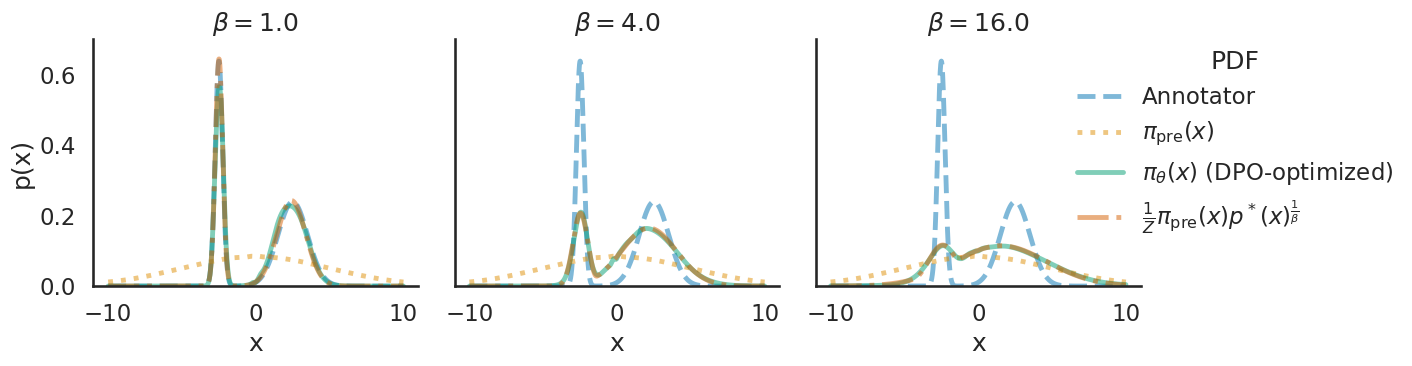

In [0]:
# @title `dpo-kl-control.pdf`
model = TOY_CONFIG.models.single_annotator.model
pretrain_state = TOY_CONFIG.pretraining.state

with custom_theme():
  common_df = pd.concat([
      pd.DataFrame({
          'p(x)': TOY_CONFIG.training.implicit_preference_distribution.prob(
              model.discretized_support
          ),
          'PDF': 'Annotator',
          'x': model.discretized_support,
      }),
      pd.DataFrame({
          'p(x)': jnp.exp(
              model.apply(
                  {'params': pretrain_state.params},
                  model.discretized_support,
                  normalized=True,
              )
          ),
          'PDF': r'$\pi_\mathrm{pre}(x)$',
          'x': model.discretized_support,
      }),
  ])

  x = model.discretized_support
  theoretical_dfs = {}
  for beta in dpo_states:
    log_unnormalized_p = (
        TOY_CONFIG.training.implicit_preference_distribution.log_prob(x) / beta
        + TOY_CONFIG.pretraining.target_distribution.log_prob(x)
    )
    width = x[1] - x[0]
    log_p = log_unnormalized_p - jax.scipy.special.logsumexp(
        jnp.log(0.5)
        + jax.scipy.special.logsumexp(
            jnp.stack([log_unnormalized_p[:-1], log_unnormalized_p[1:]]),
            axis=0,
        )
        + jnp.log(width)
    )
    theoretical_dfs[beta] = pd.DataFrame({
        'x': x,
        'p(x)': jnp.exp(log_p),
        'PDF': r'$\frac{1}{Z}\pi_\mathrm{pre}(x)p^*(x)^{\frac{1}{\beta}}$',
        'beta': beta,
    })

  _ = (
      sns.FacetGrid(
          data=pd.concat(
              [
                  pd.concat([
                      common_df.assign(beta=beta),
                      pd.DataFrame({
                          'p(x)': jnp.exp(
                              model.apply(
                                  {'params': dpo_state.params},
                                  model.discretized_support,
                                  normalized=True,
                              )
                          ),
                          'PDF': r'$\pi_\theta(x)$ (DPO-optimized)',
                          'x': model.discretized_support,
                          'beta': beta,
                      }),
                      theoretical_dfs[beta],
                  ])
                  for beta, dpo_state in dpo_states.items()
              ]
          ),
          hue='PDF',
          hue_order=(
              'Annotator',
              r'$\pi_\mathrm{pre}(x)$',
              r'$\pi_\theta(x)$ (DPO-optimized)',
              r'$\frac{1}{Z}\pi_\mathrm{pre}(x)p^*(x)^{\frac{1}{\beta}}$',
          ),
          hue_kws={
              'linestyle': ['dashed', 'dotted', 'solid', 'dashdot'],
              'alpha': [0.5] * 4,
          },
          col='beta',
          sharey=True,
          height=4,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(xticks=[-10, 0, 10], ylim=(0.0, 0.7))
      .set_titles(template=r'$\beta = {col_name}$')
      .add_legend(loc='center left', bbox_to_anchor=(0.7, 0.6))
      .tight_layout()
      .savefig('dpo-kl-control.pdf')
  )
  plt.show()

**DPO as a PBDE equation**: Under the Luce choice rule assumption for the annotator's generative process on pairwise preferences, using DPO to tune a generative model $\pi_\mathrm{pre}(x)$ (dotted orange) on preferences derived from the implicit preference distribution (dashed blue) results in a mixture of experts model between the initial model $\pi_\mathrm{pre}$ and the temperature-smoothed implicit preference distribution, as demonstrated by the agreement between the empirical (solid green) and theoretical (dash-dotted red) curves.

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

## DPO training (well-specified)

In [0]:
beta = 4.0

# Optimizer
learning_rate = optax.cosine_decay_schedule(
    init_value=TOY_CONFIG.training.learning_rate,
    decay_steps=TOY_CONFIG.training.num_steps,
    alpha=0.0,
)
optimizer = optax.adam(learning_rate=learning_rate)

# Model
model = TOY_CONFIG.models.single_annotator.model
apply_fn = functools.partial(model.apply, method=model.preference_logits)
params = TOY_CONFIG.pretraining.state.params
state = flax.jax_utils.replicate(
    TrainState.create(apply_fn=apply_fn, params=params, tx=optimizer)
)
original_state = state.replace(tx=optax.set_to_zero())

# Inputs
x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
y_dpo_beta_4 = common_utils.shard(TOY_CONFIG.training.data.y_dpo_beta_4)

# Optimization loop
print(f'Training with DPO using 𝛽 = {beta}...')

train_step_fn = jax.pmap(
    make_dpo_train_step_fn(model, beta, axis_name='batch'), axis_name='batch'
)

for _ in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
  state = train_step_fn(state, original_state, x_a, x_b, y_dpo_beta_4)

dpo_state_well_specified = flax.jax_utils.unreplicate(state)

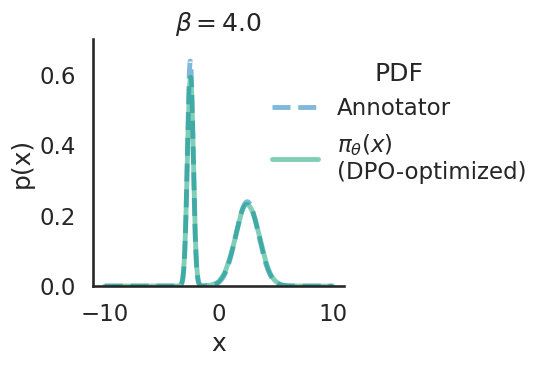

In [0]:
# @title `dpo-well-specified.pdf`
model = TOY_CONFIG.models.single_annotator.model
pretrain_state = TOY_CONFIG.pretraining.state

palette = sns.color_palette('colorblind')
with custom_theme(palette=[palette[0], palette[2]]):
  _ = (
      sns.FacetGrid(
          data=pd.concat([
              pd.DataFrame({
                  'p(x)': (
                      TOY_CONFIG.training.implicit_preference_distribution.prob(
                          model.discretized_support
                      )
                  ),
                  'PDF': 'Annotator',
                  'x': model.discretized_support,
                  'beta': 4.0,
              }),
              pd.DataFrame({
                  'p(x)': jnp.exp(
                      model.apply(
                          {'params': dpo_state_well_specified.params},
                          model.discretized_support,
                          normalized=True,
                      )
                  ),
                  'PDF': r'$\pi_\theta(x)$' + '\n(DPO-optimized)',
                  'x': model.discretized_support,
                  'beta': 4.0,
              }),
          ]),
          hue='PDF',
          hue_order=(
              'Annotator',
              r'$\pi_\theta(x)$' + '\n(DPO-optimized)',
          ),
          hue_kws={
              'linestyle': ['dashed', 'solid'],
              'alpha': [0.5] * 2,
          },
          col='beta',
          sharey=True,
          height=4,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(xticks=[-10, 0, 10], ylim=(0.0, 0.7))
      .set_titles(template=r'$\beta = {col_name}$')
      .add_legend(loc='center left', bbox_to_anchor=(0.4, 0.65))
      .tight_layout()
      .savefig('dpo-well-specified.pdf')
  )
  plt.show()

**DPO as a PBDE equation**: Theorem 2 also holds for DPO if the annotator and model share the same generative process, i.e., the model trained on annotator preferences recovers the annotator's implicit preference distribution.

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

## Geometric averaging PBDE

In [0]:
# @title Higher-order function for the "geometric averaging" training step
def make_geometric_train_step_fn(
    ebm: nn.Module, alpha: float, axis_name: str | None = None
) -> Callable[
    [TrainState, TrainState, jnp.ndarray, jnp.ndarray, jnp.ndarray], TrainState
]:
  r"""Creates a "geometric" training step function.

  The function performs one gradient step on the binary classification problem
  for the comparison outcome between x_a and x_b using the model to make a
  prediction as

      p_(y; x_a, x_b) = σ(
          α^-1 * (
            (log π_θ(x_a) - log π_pre(x_a)) - (log π_θ(x_b) - log π_pre(x_b))
          ) + (log π_pre(x_a) - log π_pre(x_b))
      )

  The resulting optimal model is a geometric average of the pretrained model and
  the annotator's implicit preference distribution.

  The training step function accepts the following as input:

  * state: The state for π_θ(x).
  * original_state: The state for π_pre(x).
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.
  * y: The batch of comparison outcomes (1 means x_a is preferred and 0 means
      x_b is preferred).

  Args:
    ebm: The flax module representing the EBM.
    axis_name: The name of the axis over which to apply the `pmean` operation on
      the gradients. If None, no `pmean` will be applied.

  Returns:
    The "geometric" training step function.
  """

  def loss(
      params: VariableDict,
      original_params: VariableDict,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> jnp.ndarray:
    method = ebm.preference_logits
    log_p = ebm.apply({'params': params}, x_a, x_b, method=method)
    log_p_pre = ebm.apply({'params': original_params}, x_a, x_b, method=method)
    logits = (1.0 / alpha) * (log_p - log_p_pre) + log_p_pre
    return -tfd.Bernoulli(logits=logits).log_prob(y).mean()

  def geometric_train_step_fn(
      state: TrainState,
      original_state: TrainState,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> TrainState:
    grads = jax.grad(loss)(state.params, original_state.params, x_a, x_b, y)
    if axis_name:
      grads = jax.lax.pmean(grads, axis_name=axis_name)
    return state.apply_gradients(grads=grads)

  return geometric_train_step_fn

In [0]:
geometric_states = {}
for alpha in (1.0, 1.0 / 4.0, 1.0 / 16.0):
  print(f'Training with geometric averaging properties using α = {alpha}...')

  # Optimizer
  learning_rate = optax.cosine_decay_schedule(
      init_value=TOY_CONFIG.training.learning_rate,
      decay_steps=TOY_CONFIG.training.num_steps,
      alpha=0.0,
  )
  optimizer = optax.adam(learning_rate=learning_rate)

  # Model
  model = TOY_CONFIG.models.single_annotator.model
  apply_fn = functools.partial(model.apply, method=model.preference_logits)
  params = TOY_CONFIG.pretraining.state.params
  state = flax.jax_utils.replicate(
      TrainState.create(apply_fn=apply_fn, params=params, tx=optimizer)
  )
  original_state = state.replace(tx=optax.set_to_zero())

  # Inputs
  x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
  x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
  y_luce = common_utils.shard(TOY_CONFIG.training.data.y_luce)

  # Optimization loop
  train_step_fn = jax.pmap(
      make_geometric_train_step_fn(model, alpha, axis_name='batch'),
      axis_name='batch',
  )

  for _ in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
    state = train_step_fn(state, original_state, x_a, x_b, y_luce)

  geometric_states[alpha] = flax.jax_utils.unreplicate(state)

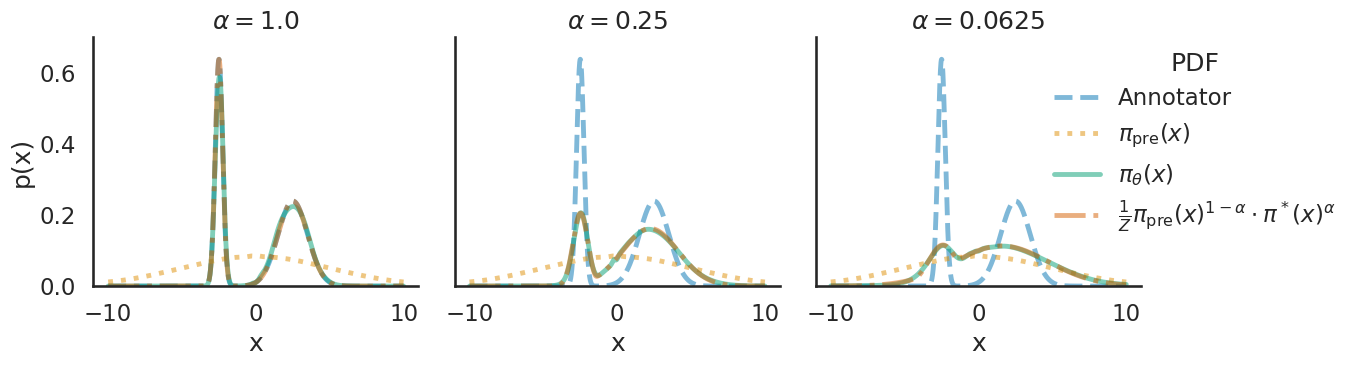

In [0]:
# @title `geometric-average.pdf`
model = TOY_CONFIG.models.single_annotator.model
pretrain_state = TOY_CONFIG.pretraining.state

with custom_theme():
  common_df = pd.concat([
      pd.DataFrame({
          'p(x)': TOY_CONFIG.training.implicit_preference_distribution.prob(
              model.discretized_support
          ),
          'PDF': 'Annotator',
          'x': model.discretized_support,
      }),
      pd.DataFrame({
          'p(x)': jnp.exp(
              model.apply(
                  {'params': pretrain_state.params},
                  model.discretized_support,
                  normalized=True,
              )
          ),
          'PDF': r'$\pi_\mathrm{pre}(x)$',
          'x': model.discretized_support,
      }),
  ])

  x = model.discretized_support
  theoretical_dfs = {}
  for alpha in geometric_states:
    log_unnormalized_p = (
        alpha * TOY_CONFIG.training.implicit_preference_distribution.log_prob(x)
        + (1.0 - alpha) * TOY_CONFIG.pretraining.target_distribution.log_prob(x)
    )
    width = x[1] - x[0]
    log_p = log_unnormalized_p - jax.scipy.special.logsumexp(
        jnp.log(0.5)
        + jax.scipy.special.logsumexp(
            jnp.stack([log_unnormalized_p[:-1], log_unnormalized_p[1:]]),
            axis=0,
        )
        + jnp.log(width)
    )
    theoretical_dfs[alpha] = pd.DataFrame({
        'x': x,
        'p(x)': jnp.exp(log_p),
        'PDF': (
            r'$\frac{1}{Z}\pi_\mathrm{pre}(x)^{1 - \alpha} \cdot'
            r' \pi^*(x)^\alpha$'
        ),
        'alpha': str(alpha),
    })

  _ = (
      sns.FacetGrid(
          data=pd.concat(
              [
                  pd.concat([
                      common_df.assign(alpha=str(alpha)),
                      pd.DataFrame({
                          'p(x)': jnp.exp(
                              model.apply(
                                  {'params': geometric_state.params},
                                  model.discretized_support,
                                  normalized=True,
                              )
                          ),
                          'PDF': r'$\pi_\theta(x)$',
                          'x': model.discretized_support,
                          'alpha': str(alpha),
                      }),
                      theoretical_dfs[alpha],
                  ])
                  for alpha, geometric_state in geometric_states.items()
              ]
          ),
          hue='PDF',
          hue_order=(
              'Annotator',
              r'$\pi_\mathrm{pre}(x)$',
              r'$\pi_\theta(x)$',
              (
                  r'$\frac{1}{Z}\pi_\mathrm{pre}(x)^{1 - \alpha} \cdot'
                  r' \pi^*(x)^\alpha$'
              ),
          ),
          hue_kws={
              'linestyle': ['dashed', 'dotted', 'solid', 'dashdot'],
              'alpha': [0.5] * 4,
          },
          col='alpha',
          sharey=True,
          height=4,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(xticks=[-10, 0, 10], ylim=(0.0, 0.7))
      .set_titles(template=r'$\alpha = {col_name}$')
      .add_legend(loc='center left', bbox_to_anchor=(0.7, 0.6))
      .tight_layout()
      .savefig('geometric-average.pdf')
  )
  plt.show()

**Geometric averaging PBDE**: Under the Luce choice rule for the annotator, using a PBDE for the model with $f(x) = \alpha^{-1}$ and $g(x) = (1 - \alpha^{-1})\log\pi_\mathrm{pre}(x)$ to tune $\pi_\mathrm{pre}(x)$ (dotted orange) on pairwise preferences derived from the implicit preference distribution (dashed blue) results in a weighted geometric average between the initial model $\pi_\mathrm{pre}$ and the implicit preference distribution, as demonstrated by the agreement between the empirical (solid green) and theoretical (dash-dotted red) curves.

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

## SLiC-HF

In [0]:
# @title Higher-order function for the SLiC-HF training step
def make_slic_train_step_fn(
    ebm: nn.Module,
    delta: float,
    lambda_: float,
    regularizer_batch_size: int,
    axis_name: str | None = None,
) -> Callable[
    [jax.Array, TrainState, TrainState, jnp.ndarray, jnp.ndarray, jnp.ndarray],
    TrainState,
]:
  r"""Creates a SLiC-HF-direct training step function.

  The training step function accepts the following as input:

  * key: The PRNG key for sampling from π_pre(x).
  * state: The state for π_θ(x).
  * original_state: The state for π_pre(x).
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.
  * y: The batch of comparison outcomes (1 means x_a is preferred and 0 means
      x_b is preferred).

  Args:
    ebm: The flax module representing the EBM.
    delta: The margin hyperparameter.
    lambda_: The pretrained model regularization hyperparameter.
    axis_name: The name of the axis over which to apply the `pmean` operation on
      the gradients. If None, no `pmean` will be applied.

  Returns:
    The SLiC-HF-direct training step function.
  """

  def loss(
      key: jax.Array,
      params: VariableDict,
      original_params: VariableDict,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> jnp.ndarray:
    method = ebm.preference_logits
    support = ebm.discretized_support
    x_sft = jax.random.choice(
        key,
        a=support,
        shape=(regularizer_batch_size,),
        p=jnp.exp(
            ebm.apply(
                {'params': original_params},
                support,
            )
        ),
        replace=True,
    )

    logits = ebm.apply({'params': params}, x_a, x_b, method=method)
    log_p_x_sft = ebm.apply({'params': params}, x_sft, normalized=True)
    return (
        nn.relu(delta - (y * logits - (1 - y) * logits)).mean()
        - lambda_ * log_p_x_sft.mean()
    )

  def slic_train_step_fn(
      key: jax.Array,
      state: TrainState,
      original_state: TrainState,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> TrainState:
    grads = jax.grad(loss, argnums=1)(
        key, state.params, original_state.params, x_a, x_b, y
    )
    if axis_name:
      grads = jax.lax.pmean(grads, axis_name=axis_name)
    return state.apply_gradients(grads=grads)

  return slic_train_step_fn

In [0]:
key = TOY_CONFIG.random.key

slic_hf_states = {}
for delta, lambda_ in itertools.product(
    (0.0, 0.25, 0.5, 1.0, 2.0),
    (0.0, 1.0),
):
  print(f'Training with SLiC-HF using δ = {delta} and λ = {lambda_}...')

  # PRNG
  training_key = fold_in_str(key, f'SLiC-HF-{delta}-{lambda_}')

  # Optimizer
  learning_rate = optax.cosine_decay_schedule(
      init_value=TOY_CONFIG.training.learning_rate,
      decay_steps=TOY_CONFIG.training.num_steps,
      alpha=0.0,
  )
  optimizer = optax.adam(learning_rate=learning_rate)

  # Model
  model = TOY_CONFIG.models.single_annotator.model
  apply_fn = functools.partial(model.apply, method=model.preference_logits)
  params = TOY_CONFIG.pretraining.state.params
  state = flax.jax_utils.replicate(
      TrainState.create(apply_fn=apply_fn, params=params, tx=optimizer)
  )
  original_state = state.replace(tx=optax.set_to_zero())

  # Inputs
  x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
  x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
  y_luce = common_utils.shard(TOY_CONFIG.training.data.y_luce)

  # Optimization loop
  batch_size = TOY_CONFIG.training.slic.regularizer_batch_size
  train_step_fn = jax.pmap(
      make_slic_train_step_fn(
          model, delta, lambda_, batch_size, axis_name='batch'
      ),
      axis_name='batch',
  )

  for i in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
    step_key = jax.random.split(
        jax.random.fold_in(training_key, i), jax.local_device_count()
    )
    state = train_step_fn(step_key, state, original_state, x_a, x_b, y_luce)

  slic_hf_states[(delta, lambda_)] = flax.jax_utils.unreplicate(state)

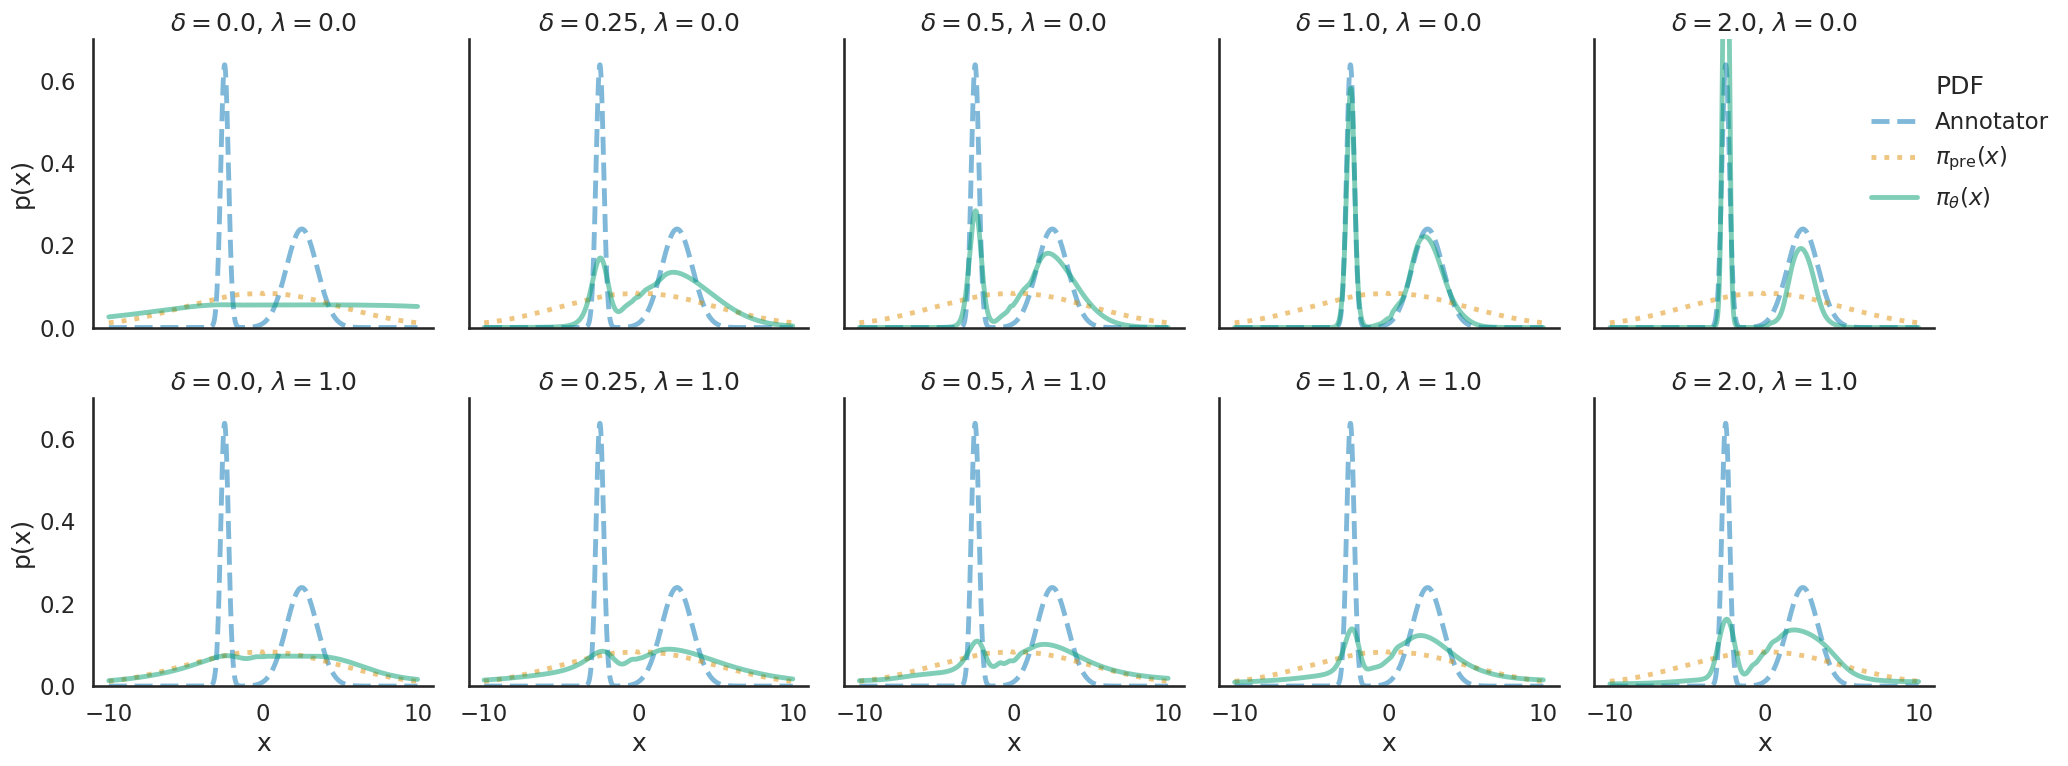

In [0]:
# @title `slic-hf.pdf`
model = TOY_CONFIG.models.single_annotator.model
pretrain_state = TOY_CONFIG.pretraining.state

with custom_theme():
  common_df = pd.concat([
      pd.DataFrame({
          'p(x)': TOY_CONFIG.training.implicit_preference_distribution.prob(
              model.discretized_support
          ),
          'PDF': 'Annotator',
          'x': model.discretized_support,
      }),
      pd.DataFrame({
          'p(x)': jnp.exp(
              model.apply(
                  {'params': pretrain_state.params},
                  model.discretized_support,
                  normalized=True,
              )
          ),
          'PDF': r'$\pi_\mathrm{pre}(x)$',
          'x': model.discretized_support,
      }),
  ])

  _ = (
      sns.FacetGrid(
          data=pd.concat(
              [
                  pd.concat([
                      common_df.assign(delta=str(delta), lambda_=str(lambda_)),
                      pd.DataFrame({
                          'p(x)': jnp.exp(
                              model.apply(
                                  {'params': slic_hf_state.params},
                                  model.discretized_support,
                                  normalized=True,
                              )
                          ),
                          'PDF': r'$\pi_\theta(x)$',
                          'x': model.discretized_support,
                          'delta': str(delta),
                          'lambda_': str(lambda_),
                      }),
                  ])
                  for (delta, lambda_), slic_hf_state in slic_hf_states.items()
              ]
          ),
          hue='PDF',
          hue_order=(
              'Annotator',
              r'$\pi_\mathrm{pre}(x)$',
              r'$\pi_\theta(x)$',
          ),
          hue_kws={
              'linestyle': ['dashed', 'dotted', 'solid', 'dashdot'],
              'alpha': [0.5] * 4,
          },
          col='delta',
          row='lambda_',
          sharey=True,
          height=4,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(xticks=[-10, 0, 10], ylim=(0.0, 0.7))
      .set_titles(template=r'$\delta = {col_name}$, $\lambda = {row_name}$')
      .add_legend(loc='center left', bbox_to_anchor=(0.85, 0.8))
      .tight_layout()
      .savefig('slic-hf.pdf')
  )
  plt.show()

**SLiC-HF**: Using SLiC-HF-direct to tune a generative model $\pi_\mathrm{pre}(x)$ (dotted orange) on pairwise preferences derived from the implicit preference distribution (dashed blue) results in different adapted models (solid green) depending on the choice of hyperparameters $\delta$ and $\lambda$.

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

## IPO

In [0]:
# @title Higher-order function for the IPO training step
def make_ipo_train_step_fn(
    ebm: nn.Module, tau: float, axis_name: str | None = None
) -> Callable[
    [TrainState, TrainState, jnp.ndarray, jnp.ndarray, jnp.ndarray], TrainState
]:
  r"""Creates an IPO training step function.

  The training step function accepts the following as input:

  * state: The state for π_θ(x).
  * original_state: The state for π_pre(x).
  * x_a: The batch containing the first element in each observation pair.
  * x_b: The batch containing the second element in each observation pair.
  * y: The batch of comparison outcomes (1 means x_a is preferred and 0 means
      x_b is preferred).

  Args:
    ebm: The flax module representing the EBM.
    tau: The margin hyperparameter.
    axis_name: The name of the axis over which to apply the `pmean` operation on
      the gradients. If None, no `pmean` will be applied.

  Returns:
    The IPO training step function.
  """

  def loss(
      params: VariableDict,
      original_params: VariableDict,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> jnp.ndarray:
    method = ebm.preference_logits
    logits = ebm.apply({'params': params}, x_a, x_b, method=method) - ebm.apply(
        {'params': original_params}, x_a, x_b, method=method
    )
    return ((y * logits - (1 - y) * logits - 1.0 / (2.0 * tau)) ** 2).mean()

  def ipo_train_step_fn(
      state: TrainState,
      original_state: TrainState,
      x_a: jnp.ndarray,
      x_b: jnp.ndarray,
      y: jnp.ndarray,
  ) -> TrainState:
    grads = jax.grad(loss)(state.params, original_state.params, x_a, x_b, y)
    if axis_name:
      grads = jax.lax.pmean(grads, axis_name=axis_name)
    return state.apply_gradients(grads=grads)

  return ipo_train_step_fn

In [0]:
ipo_states = {}
for tau in (0.1, 0.5, 1.0):
  print(f'Training with IPO using τ = {tau}...')

  # Optimizer
  learning_rate = optax.cosine_decay_schedule(
      init_value=TOY_CONFIG.training.learning_rate,
      decay_steps=TOY_CONFIG.training.num_steps,
      alpha=0.0,
  )
  optimizer = optax.adam(learning_rate=learning_rate)

  # Model
  model = TOY_CONFIG.models.single_annotator.model
  apply_fn = functools.partial(model.apply, method=model.preference_logits)
  params = TOY_CONFIG.pretraining.state.params
  state = flax.jax_utils.replicate(
      TrainState.create(apply_fn=apply_fn, params=params, tx=optimizer)
  )
  original_state = state.replace(tx=optax.set_to_zero())

  # Inputs
  x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
  x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
  y_luce = common_utils.shard(TOY_CONFIG.training.data.y_luce)

  # Optimization loop
  train_step_fn = jax.pmap(
      make_ipo_train_step_fn(model, tau, axis_name='batch'), axis_name='batch'
  )

  for i in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
    state = train_step_fn(state, original_state, x_a, x_b, y_luce)

  ipo_states[tau] = flax.jax_utils.unreplicate(state)

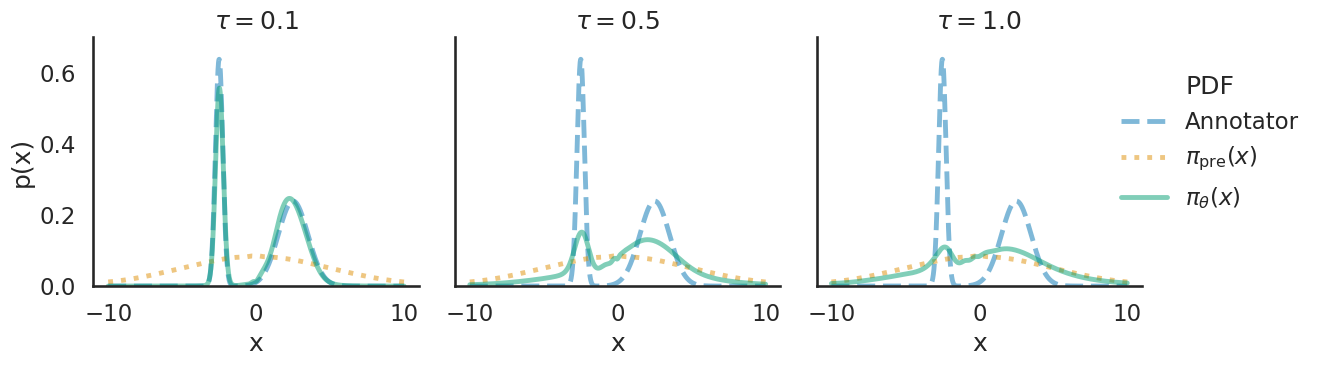

In [0]:
# @title `ipo.pdf`
model = TOY_CONFIG.models.single_annotator.model
pretrain_state = TOY_CONFIG.pretraining.state

with custom_theme():
  common_df = pd.concat([
      pd.DataFrame({
          'p(x)': TOY_CONFIG.training.implicit_preference_distribution.prob(
              model.discretized_support
          ),
          'PDF': 'Annotator',
          'x': model.discretized_support,
      }),
      pd.DataFrame({
          'p(x)': jnp.exp(
              model.apply(
                  {'params': pretrain_state.params},
                  model.discretized_support,
                  normalized=True,
              )
          ),
          'PDF': r'$\pi_\mathrm{pre}(x)$',
          'x': model.discretized_support,
      }),
  ])

  _ = (
      sns.FacetGrid(
          data=pd.concat(
              [
                  pd.concat([
                      common_df.assign(tau=str(tau)),
                      pd.DataFrame({
                          'p(x)': jnp.exp(
                              model.apply(
                                  {'params': ipo_state.params},
                                  model.discretized_support,
                                  normalized=True,
                              )
                          ),
                          'PDF': r'$\pi_\theta(x)$',
                          'x': model.discretized_support,
                          'tau': str(tau),
                      }),
                  ])
                  for tau, ipo_state in ipo_states.items()
              ]
          ),
          hue='PDF',
          hue_order=(
              'Annotator',
              r'$\pi_\mathrm{pre}(x)$',
              r'$\pi_\theta(x)$',
          ),
          hue_kws={
              'linestyle': ['dashed', 'dotted', 'solid'],
              'alpha': [0.5] * 3,
          },
          col='tau',
          sharey=True,
          height=4,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(xticks=[-10, 0, 10], ylim=(0.0, 0.7))
      .set_titles(template=r'$\tau = {col_name}$')
      .add_legend(loc='center left', bbox_to_anchor=(0.8, 0.6))
      .tight_layout()
      .savefig('ipo.pdf')
  )
  plt.show()

**IPO**: Using IPO to tune a generative model $\pi_\mathrm{pre}(x)$ (dotted orange) on pairwise preferences derived from the implicit preference distribution (dashed blue) results in different adapted models (solid green) depending on the choice of the $\tau$ hyperparameter.

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

## Model adaptation with preference misspecification

In [0]:
# Optimizer
learning_rate = optax.cosine_decay_schedule(
    init_value=TOY_CONFIG.training.learning_rate,
    decay_steps=TOY_CONFIG.training.num_steps,
    alpha=0.0,
)
optimizer = optax.adam(learning_rate=learning_rate)

# Model
model = TOY_CONFIG.models.single_annotator.model
apply_fn = functools.partial(model.apply, method=model.preference_logits)
params = TOY_CONFIG.pretraining.state.params
state = flax.jax_utils.replicate(
    TrainState.create(apply_fn=apply_fn, params=params, tx=optimizer)
)

# Inputs
x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
y_multi_luce = common_utils.shard(TOY_CONFIG.training.data.y_multi_luce)

# Optimization loop
print(f'Training on multi-annotator preference with a misspecified model...')

train_step_fn = jax.pmap(
    make_reward_train_step_fn(model, axis_name='batch'), axis_name='batch'
)

for _ in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
  state = train_step_fn(state, x_a, x_b, y_multi_luce)

misspecified_state = flax.jax_utils.unreplicate(state)

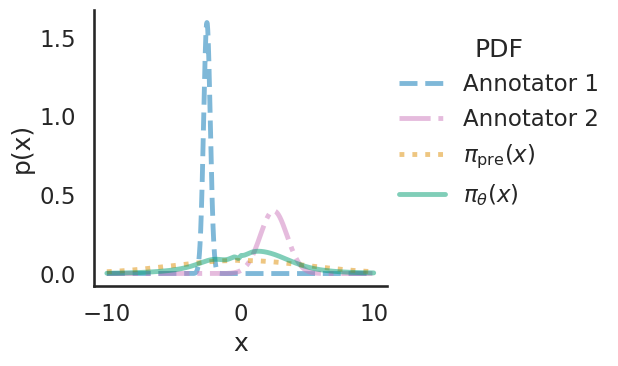

In [0]:
# @title `multi-annotator-misspecified.pdf`
model = TOY_CONFIG.models.single_annotator.model
pretrain_state = TOY_CONFIG.pretraining.state

components = TOY_CONFIG.training.implicit_preference_distribution.components
p_annotator_0 = components[0].prob(model.discretized_support)
p_annotator_1 = components[1].prob(model.discretized_support)

palette = sns.color_palette('colorblind')
with custom_theme(palette=[palette[0], palette[4], palette[1], palette[2]]):
  _ = (
      sns.FacetGrid(
          data=pd.concat([
              pd.DataFrame({
                  'p(x)': p_annotator_0,
                  'PDF': 'Annotator 1',
                  'x': model.discretized_support,
              }),
              pd.DataFrame({
                  'p(x)': p_annotator_1,
                  'PDF': 'Annotator 2',
                  'x': model.discretized_support,
              }),
              pd.DataFrame({
                  'p(x)': jnp.exp(
                      model.apply(
                          {'params': pretrain_state.params},
                          model.discretized_support,
                          normalized=True,
                      )
                  ),
                  'PDF': r'$\pi_\mathrm{pre}(x)$',
                  'x': model.discretized_support,
              }),
              pd.DataFrame({
                  'p(x)': jnp.exp(
                      model.apply(
                          {'params': misspecified_state.params},
                          model.discretized_support,
                          normalized=True,
                      )
                  ),
                  'PDF': r'$\pi_\theta(x)$',
                  'x': model.discretized_support,
              }),
          ]),
          hue='PDF',
          hue_order=[
              'Annotator 1',
              'Annotator 2',
              r'$\pi_\mathrm{pre}(x)$',
              r'$\pi_\theta(x)$',
          ],
          hue_kws={
              'alpha': [0.5] * 4,
              'linestyle': ['dashed', 'dashdot', 'dotted', 'solid'],
          },
          height=4,
          aspect=1.1,
      )
      .map_dataframe(sns.lineplot, x='x', y='p(x)')
      .set(xticks=[-10, 0, 10])
      .add_legend(loc='center left', bbox_to_anchor=(0.6, 0.65))
      .tight_layout()
      .savefig('multi-annotator-misspecified.pdf')
  )
  plt.show()

**Annotator misspecification**: If preferences are aggregated across two annotators (dashed blue, dot-dashed pink) but the model is adapted under a single-annotator assumption, it fails to capture either annotator's PDF (solid green).

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

## Model adaptation with a well-specified annotator behavior model

In [0]:
# PRNG
key_prior = fold_in_str(TOY_CONFIG.random.key, 'multi_model')
key_0 = fold_in_str(TOY_CONFIG.random.key, 'energy_function_0_noise')
key_1 = fold_in_str(TOY_CONFIG.random.key, 'energy_function_1_noise')

# Optimizer
learning_rate = optax.cosine_decay_schedule(
    init_value=TOY_CONFIG.training.learning_rate,
    decay_steps=TOY_CONFIG.training.num_steps,
    alpha=0.0,
)
optimizer = optax.adam(learning_rate=learning_rate)

# Model
model = TOY_CONFIG.models.multi_annotator.model
apply_fn = functools.partial(model.apply, method=model.preference_logits)
init_params = model.init(key_prior, jnp.zeros((1,)))['params']
pretrained_params = TOY_CONFIG.pretraining.state.params['energy_function']
params = init_params | {
    'energy_function_0': add_parameter_noise(
        key=key_0, params=pretrained_params, scale=1e-4
    ),
    'energy_function_1': add_parameter_noise(
        key=key_1, params=pretrained_params, scale=1e-4
    ),
}
multi_pretrain_state = TrainState.create(
    apply_fn=apply_fn, params=params, tx=optimizer
)
state = flax.jax_utils.replicate(multi_pretrain_state)

# Inputs
x_a = common_utils.shard(TOY_CONFIG.training.data.x_a)
x_b = common_utils.shard(TOY_CONFIG.training.data.x_b)
y_multi_luce = common_utils.shard(TOY_CONFIG.training.data.y_multi_luce)

# Optimization loop
print(f'Training on multi-annotator preference with a well-specified model...')

train_step_fn = jax.pmap(
    make_reward_train_step_fn(model, axis_name='batch'), axis_name='batch'
)

for _ in tqdm.notebook.tqdm(range(TOY_CONFIG.training.num_steps)):
  state = train_step_fn(state, x_a, x_b, y_multi_luce)

well_specified_state = flax.jax_utils.unreplicate(state)

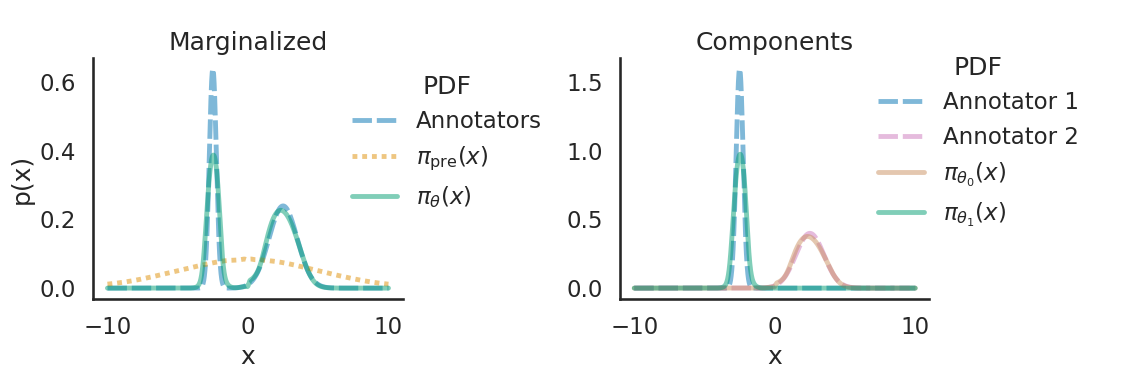

In [0]:
# @title `multi-annotator-well-specified.pdf`
model = TOY_CONFIG.models.multi_annotator.model
support = model.discretized_support

p_annotators = TOY_CONFIG.training.implicit_preference_distribution.prob(
    support
)
components = TOY_CONFIG.training.implicit_preference_distribution.components
p_annotator_0 = components[0].prob(support)
p_annotator_1 = components[1].prob(support)

p_pre = jnp.exp(model.apply({'params': multi_pretrain_state.params}, support))
p_model = jnp.exp(model.apply({'params': well_specified_state.params}, support))
logits_0 = jnp.array([0.0, -jnp.inf])
p_model_0 = jnp.exp(
    model.apply(
        {'params': well_specified_state.params | {'prior_logits': logits_0}},
        support,
    )
)
logits_1 = jnp.array([-jnp.inf, 0.0])
p_model_1 = jnp.exp(
    model.apply(
        {'params': well_specified_state.params | {'prior_logits': logits_1}},
        support,
    )
)


def _to_df(p_x, pdf, view):
  return pd.DataFrame({'p(x)': p_x, 'PDF': pdf, 'x': support, 'View': view})


with custom_theme():
  data = pd.concat([
      _to_df(p_annotators, 'Annotators', 'Marginalized'),
      _to_df(p_pre, r'$\pi_\mathrm{pre}(x)$', 'Marginalized'),
      _to_df(p_model, r'$\pi_\theta(x)$', 'Marginalized'),
      _to_df(p_annotator_0, 'Annotator 1', 'Components'),
      _to_df(p_annotator_1, 'Annotator 2', 'Components'),
      _to_df(p_model_0, r'$\pi_{\theta_0}(x)$', 'Components'),
      _to_df(p_model_1, r'$\pi_{\theta_1}(x)$', 'Components'),
  ])
  dashes = {
      'Annotators': (4, 1),
      'Annotator 1': (4, 1),
      'Annotator 2': (4, 1),
      r'$\pi_\mathrm{pre}(x)$': (1, 1),
      r'$\pi_\theta(x)$': '',
      r'$\pi_{\theta_0}(x)$': '',
      r'$\pi_{\theta_1}(x)$': '',
  }

  g = sns.FacetGrid(
      data=data,
      hue='PDF',
      col='View',
      sharey=False,
      height=4,
      aspect=1.4,
  )

  for col_var, facet_df in data.groupby('View'):
    ax = g.axes[0, g.col_names.index(col_var)]
    palette = 'colorblind'
    if col_var == 'Components':
      palette = sns.color_palette('colorblind')
      palette = [palette[0], palette[4], palette[5], palette[2]]

    _ = sns.lineplot(
        data=facet_df,
        x='x',
        y='p(x)',
        hue='PDF',
        alpha=0.5,
        style='PDF',
        dashes=dashes,
        palette=palette,
        ax=ax,
    )
    _ = ax.set(xlabel='', ylabel='')

    _ = sns.move_legend(
        ax,
        loc='center left',
        bbox_to_anchor=(0.65, 0.65),
        frameon=False,
        borderpad=2,
    )
    for lh in ax.get_legend().legend_handles:
      _ = lh.set_alpha(0.5)

  _ = (
      g.set_axis_labels('x', 'p(x)')
      .set_titles(template='{col_name}')
      .tight_layout()
      .savefig('multi-annotator-well-specified.pdf')
  )
  plt.show()

**Well-specified training**: Choosing the correct annotator behavior model allows to recover the correct marginal implicit preference distribution (left) and individual implicit preference distributions (right), even without annotator IDs in the preference data.

The x-axis represents the support for the random variable $x$ and the y-axis represents the probability density.

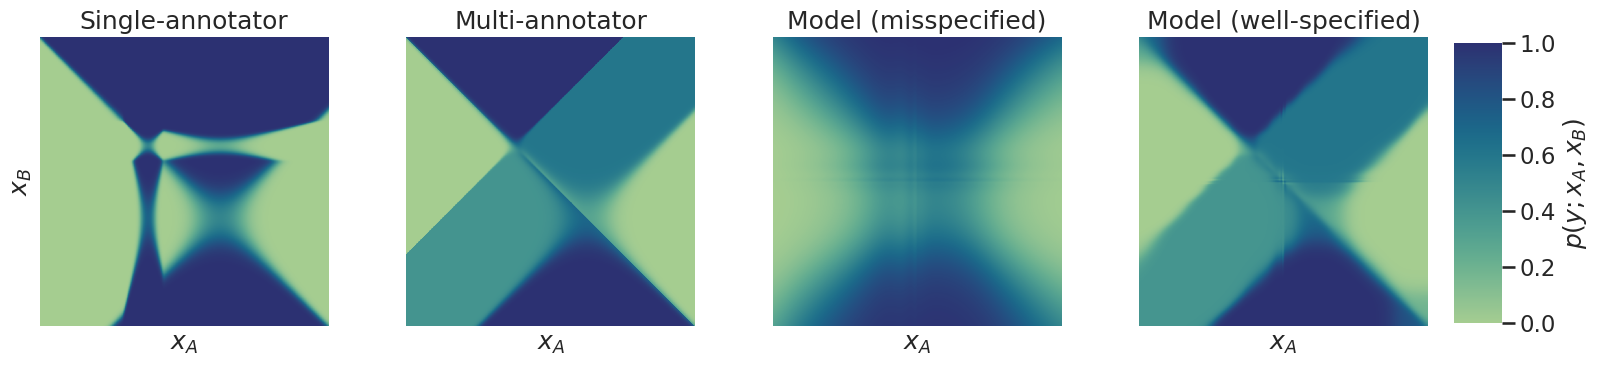

In [0]:
# @title `heatmap.png`
def _draw_heatmap(*args, **kwargs):
  data = kwargs.pop('data')
  d = data.pivot(index=args[1], columns=args[0], values=args[2])
  ax = sns.heatmap(d, **kwargs)


@jax.jit
def _single_annotator_preference_logit_fn(x_a, x_b):
  distribution = TOY_CONFIG.training.implicit_preference_distribution
  return distribution.log_prob(x_a) - distribution.log_prob(x_b)


@jax.jit
def _multi_annotator_preference_logit_fn(x_a, x_b):
  distribution = TOY_CONFIG.training.implicit_preference_distribution
  conditional_r_a = jnp.stack(
      [component.log_prob(x_a) for component in distribution.components]
  )
  conditional_r_b = jnp.stack(
      [component.log_prob(x_b) for component in distribution.components]
  )
  p = (
      distribution.cat.probs[:, None]
      * nn.sigmoid(conditional_r_a - conditional_r_b)
  ).sum(axis=0)
  return jnp.log(p) - jnp.log(1 - p)


coarse_support = jnp.linspace(
    TOY_CONFIG.random.low, TOY_CONFIG.random.high, num=2**10
)
indices = pd.MultiIndex.from_product(
    (np.asarray(coarse_support), np.asarray(coarse_support)),
    names=('$x_A$', '$x_B$'),
)

with custom_theme(), warnings.catch_warnings():
  warnings.simplefilter('ignore')
  g = sns.FacetGrid(
      data=pd.concat([
          pd.DataFrame(
              np.asarray(
                  jax.nn.sigmoid(
                      _single_annotator_preference_logit_fn(
                          *np.asarray(indices.to_list()).T
                      )
                  )
              ),
              index=indices,
              columns=('$p(y ; x_A, x_B)$',),
          )
          .reset_index()
          .assign(Behavior='Single-annotator'),
          pd.DataFrame(
              np.asarray(
                  jax.nn.sigmoid(
                      _multi_annotator_preference_logit_fn(
                          *np.asarray(indices.to_list()).T
                      )
                  )
              ),
              index=indices,
              columns=('$p(y ; x_A, x_B)$',),
          )
          .reset_index()
          .assign(Behavior='Multi-annotator'),
          pd.DataFrame(
              np.asarray(
                  jax.nn.sigmoid(
                      TOY_CONFIG.models.single_annotator.model.apply(
                          {'params': misspecified_state.params},
                          *np.asarray(indices.to_list()).T,
                          method=TOY_CONFIG.models.single_annotator.model.preference_logits,
                      )
                  )
              ),
              index=indices,
              columns=('$p(y ; x_A, x_B)$',),
          )
          .reset_index()
          .assign(Behavior='Model (misspecified)'),
          pd.DataFrame(
              np.asarray(
                  jax.nn.sigmoid(
                      TOY_CONFIG.models.multi_annotator.model.apply(
                          {'params': well_specified_state.params},
                          *np.asarray(indices.to_list()).T,
                          method=TOY_CONFIG.models.multi_annotator.model.preference_logits,
                      )
                  )
              ),
              index=indices,
              columns=('$p(y ; x_A, x_B)$',),
          )
          .reset_index()
          .assign(Behavior='Model (well-specified)'),
      ]),
      height=4.0,
      col='Behavior',
      col_order=[
          'Single-annotator',
          'Multi-annotator',
          'Model (misspecified)',
          'Model (well-specified)',
      ],
  )
  cbar_ax = g.fig.add_axes([0.95, 0.15, 0.03, 0.7])
  _ = (
      g.set_titles(template='{col_name}')
      .map_dataframe(
          _draw_heatmap,
          '$x_A$',
          '$x_B$',
          '$p(y ; x_A, x_B)$',
          square=True,
          xticklabels=False,
          yticklabels=False,
          cmap='crest',
          cbar_ax=cbar_ax,
          cbar_kws={'label': '$p(y ; x_A, x_B)$'},
      )
      .tight_layout()
      .savefig('heatmap.png', dpi=300)
  )
  plt.show()

**Preference distributions**: $\mathrm{Prob}(x_A \succ x_B)$ for single-annotator and multi-annotator behavior (left two plots) as well as models adapted with a misspecified and well-specified annotator behavior model (right two plots). The large regions of near-0.5 probability in the multi-annotator case (second plot) are caused by strong but opposing preferences for the two annotators, which cannot be captured by a single-annotator reward model (third plot).

The x-axis represents the support for $x_A$ and the y-axis represents the support for $x_B$.

# LM1B experiments

In [0]:
#@title Download LM1B model checkpoints
print('LM1B model checkpoints will be made available soon...')

## Class and function definitions

### Utility functions

In [0]:
def encode_strings(
    tokenizer: tftxt.SentencepieceTokenizer,
    strings: Sequence[str],
    max_length: int,
    remove_eos_token: bool = False,
) -> jnp.ndarray:
  """Tokenizes input strings.

  Args:
    tokenizer: The tokenizer used to encode the strings.
    strings: The input strings.
    max_length: The maximum sequence length.
    remove_eos_token: If True, removes the end-of-sentence token from the
      encoded strings.

  Returns:
    The tokenized strings.

  Raises:
    ValueError, if one or more input strings encode into too many tokens.
  """
  tokenized_batch = jnp.zeros((len(strings), max_length), jnp.int32)
  for idx, string in enumerate(strings):
    tokens = tokenizer.tokenize(string).numpy()
    if tokens.shape[0] > max_length:
      raise ValueError(
          f'sequence {string} encodes into {tokens.shape[0]} tokens, which is '
          f'larger than the {max_length} tokens allowed.'
      )
    if remove_eos_token:
      tokens = tokens[:-1]
    tokenized_batch = tokenized_batch.at[idx, : tokens.shape[0]].set(tokens)
  return tokenized_batch

In [0]:
def decode_tokens(
    tokenizer: tftxt.SentencepieceTokenizer,
    tokens: jnp.ndarray,
    eos_id: int,
) -> str:
  """Decodes a 1D sequence of tokens into strings.

  Args:
    tokenizer: The tokenizer used to decode the tokens.
    tokens: The 1D sequence of tokens.
    eos_id: The ID of the end-of-sentence token.

  Returns:
    The decoded tokens.

  Raises:
    ValueError, if the sequence of tokens is malformed (because it doesn't
    contain exactly one EOS token).
  """
  tokens = np.asarray(tokens)
  if not ((tokens == eos_id).sum(axis=-1) == 1).all():
    raise ValueError('the tokens do not contain exactly one EOS token.')
  valid_tokens = tokens[: np.argmax(tokens == eos_id) + 1].astype(np.int32)
  return tokenizer.detokenize(valid_tokens).numpy().decode('utf-8')

In [0]:
def load_checkpoint(
    model: nn.Module, path: str, per_device_batch_size: int, max_length: int
) -> VariableDict:
  """Loads a model checkpoint.

  Args:
    model: The model.
    path: The checkpoint path.
    per_device_batch_size: The per-device batch size.
    max_length: The maximum sequence length.

  Returns:
    The checkpoint's model parameters.
  """
  return checkpoints.restore_checkpoint(
      path,
      TrainState.create(
          apply_fn=model.apply,
          params=model.init(
              # `model.init` is only called to create the VariablesDict
              # structure, the initial parameters are immediately replaced with
              # checkpoint parameters.
              jax.random.PRNGKey(0),
              jnp.ones((per_device_batch_size, max_length), jnp.float32),
          )['params'],
          tx=optax.set_to_zero(),
      ),
  ).params

In [0]:
def load_tokenizer(vocab_path: str) -> tftxt.SentencepieceTokenizer:
  """Loads a SentencePiece tokenizer.

  Args:
    vocab_path: The path to the serialized SentencePiece model.

  Returns:
    The tokenizer.
  """
  return tftxt.SentencepieceTokenizer(
      model=epath.Path(vocab_path).read_bytes(),
      add_bos=False,
      add_eos=True,
      reverse=False,
  )

### Flax modules

In [0]:
# @title Contents of the `flax.examples.lm1b.models` module
@struct.dataclass
class TransformerConfig:
  """Global hyperparameters used to minimize obnoxious kwarg plumbing."""

  vocab_size: int
  output_vocab_size: int
  share_embeddings: bool = False
  logits_via_embedding: bool = False
  dtype: Any = jnp.float32
  emb_dim: int = 512
  num_heads: int = 8
  num_layers: int = 6
  qkv_dim: int = 512
  mlp_dim: int = 2048
  max_len: int = 2048
  dropout_rate: float = 0.1
  attention_dropout_rate: float = 0.1
  deterministic: bool = False
  decode: bool = False
  kernel_init: Callable = nn.initializers.xavier_uniform()
  bias_init: Callable = nn.initializers.normal(stddev=1e-6)
  posemb_init: Callable | None = None


def shift_right(x, axis=1):
  """Shift the input to the right by padding and slicing on axis."""
  pad_widths = [(0, 0)] * len(x.shape)
  pad_widths[axis] = (1, 0)
  padded = jnp.pad(
      x, pad_widths, mode='constant', constant_values=x.dtype.type(0)
  )
  return lax.dynamic_slice_in_dim(padded, 0, padded.shape[axis] - 1, axis)


def shift_inputs(x, segment_ids=None, axis=1):
  """Shift inputs and replace EOS by 0 for packed inputs."""
  shifted = shift_right(x, axis=axis)
  # For packed targets, the first shifted token of a new sequence is made
  # 0, rather than being the EOS token for the last sequence.
  if segment_ids is not None:
    shifted *= segment_ids == shift_right(segment_ids, axis=axis)
  return shifted


def sinusoidal_init(max_len=2048, min_scale=1.0, max_scale=10000.0):
  """1D Sinusoidal Position Embedding Initializer.

  Args:
      max_len: maximum possible length for the input.
      min_scale: float: minimum frequency-scale in sine grating.
      max_scale: float: maximum frequency-scale in sine grating.

  Returns:
      output: init function returning `(1, max_len, d_feature)`
  """

  def init(key, shape, dtype=np.float32):
    """Sinusoidal init."""
    del key, dtype
    d_feature = shape[-1]
    pe = np.zeros((max_len, d_feature), dtype=np.float32)
    position = np.arange(0, max_len)[:, np.newaxis]
    scale_factor = -np.log(max_scale / min_scale) / (d_feature // 2 - 1)
    div_term = min_scale * np.exp(np.arange(0, d_feature // 2) * scale_factor)
    pe[:, : d_feature // 2] = np.sin(position * div_term)
    pe[:, d_feature // 2 : 2 * (d_feature // 2)] = np.cos(position * div_term)
    pe = pe[np.newaxis, :, :]  # [1, max_len, d_feature]
    return jnp.array(pe)

  return init


class AddPositionEmbs(nn.Module):
  """Adds (optionally learned) positional embeddings to the inputs.

  Args:
    config: TransformerConfig dataclass containing hyperparameters.
    decode: whether to run in single-position autoregressive mode.
  """

  config: TransformerConfig
  decode: bool = False

  @nn.compact
  def __call__(self, inputs, inputs_positions=None):
    """Applies AddPositionEmbs module.

    By default this layer uses a fixed sinusoidal embedding table. If a
    learned position embedding is desired, pass an initializer to
    posemb_init in the configuration.

    Args:
      inputs: input data.
      inputs_positions: input position indices for packed sequences.

    Returns:
      output: `(bs, timesteps, in_dim)`
    """
    config = self.config
    # inputs.shape is (batch_size, seq_len, emb_dim)
    assert inputs.ndim == 3, (
        'Number of dimensions should be 3, but it is: %d' % inputs.ndim
    )
    length = inputs.shape[1]
    pos_emb_shape = (1, config.max_len, inputs.shape[-1])
    if config.posemb_init is None:
      # Use a fixed (non-learned) sinusoidal position embedding.
      pos_embedding = sinusoidal_init(max_len=config.max_len)(
          None, pos_emb_shape, None
      )
    else:
      pos_embedding = self.param(
          'pos_embedding', config.posemb_init, pos_emb_shape
      )
    pe = pos_embedding[:, :length, :]

    # We use a cache position index for tracking decoding position.
    if self.decode:
      is_initialized = self.has_variable('cache', 'cache_index')
      cache_index = self.variable(
          'cache', 'cache_index', lambda: jnp.array(0, dtype=jnp.uint32)
      )
      if is_initialized:
        i = cache_index.value
        cache_index.value = i + 1
        _, _, df = pos_embedding.shape
        pe = lax.dynamic_slice(pos_embedding, jnp.array((0, i, 0)), (1, 1, df))
    if inputs_positions is None:
      # normal unpacked case:
      return inputs + pe
    else:
      # for packed data we need to use known position indices:
      return inputs + jnp.take(pe[0], inputs_positions, axis=0)


class MlpBlock(nn.Module):
  """Transformer MLP / feed-forward block.

  Args:
    config: TransformerConfig dataclass containing hyperparameters.
    out_dim: optionally specify out dimension.
  """

  config: TransformerConfig
  out_dim: int | None = None

  @nn.compact
  def __call__(self, inputs):
    """Applies Transformer MlpBlock module."""
    config = self.config
    actual_out_dim = inputs.shape[-1] if self.out_dim is None else self.out_dim
    x = nn.Dense(
        config.mlp_dim,
        dtype=config.dtype,
        kernel_init=config.kernel_init,
        bias_init=config.bias_init,
    )(inputs)
    x = nn.relu(x)
    x = nn.Dropout(rate=config.dropout_rate)(
        x, deterministic=config.deterministic
    )
    output = nn.Dense(
        actual_out_dim,
        dtype=config.dtype,
        kernel_init=config.kernel_init,
        bias_init=config.bias_init,
    )(x)
    output = nn.Dropout(rate=config.dropout_rate)(
        output, deterministic=config.deterministic
    )
    return output


class EncoderDecoder1DBlock(nn.Module):
  """Transformer encoder-decoder layer.

  Args:
    config: TransformerConfig dataclass containing hyperparameters.
  """

  config: TransformerConfig

  @nn.compact
  def __call__(self, inputs, decoder_mask=None, encoder_decoder_mask=None):
    """Applies EncoderDecoder1DBlock module.

    Args:
      inputs: input data for decoder
      decoder_mask: decoder self-attention mask.
      encoder_decoder_mask: encoder-decoder attention mask.

    Returns:
      output after transformer encoder-decoder block.
    """
    config = self.config

    # Decoder block.
    assert inputs.ndim == 3
    x = nn.LayerNorm(dtype=config.dtype)(inputs)
    x = nn.SelfAttention(
        num_heads=config.num_heads,
        dtype=config.dtype,
        qkv_features=config.qkv_dim,
        kernel_init=config.kernel_init,
        bias_init=config.bias_init,
        use_bias=False,
        broadcast_dropout=False,
        dropout_rate=config.attention_dropout_rate,
        deterministic=config.deterministic,
        decode=config.decode,
    )(x, decoder_mask)
    x = nn.Dropout(rate=config.dropout_rate)(
        x, deterministic=config.deterministic
    )
    x = x + inputs

    # MLP block.
    z = nn.LayerNorm(dtype=config.dtype)(x)
    z = MlpBlock(config=config)(z)

    return x + z


class Decoder(nn.Module):
  """Transformer Model Decoder for sequence to sequence translation.

  Args:
    config: TransformerConfig dataclass containing hyperparameters.
    shared_embedding: a shared embedding layer to use.
  """

  config: TransformerConfig
  shared_embedding: Any = None

  @nn.compact
  def __call__(
      self,
      inputs,
      inputs_positions=None,
      inputs_segmentation=None,
      decoder_mask=None,
      encoder_decoder_mask=None,
  ):
    """Applies Transformer model on the inputs.

    Args:
      encoded: encoded input data from encoder.
      inputs: input data.
      inputs_positions: input subsequence positions for packed examples.
      inputs_segmentation: input segmentation info for packed examples.
      decoder_mask: decoder self-attention mask.
      encoder_decoder_mask: encoder-decoder attention mask.

    Returns:
      output of a transformer decoder.
    """
    config = self.config
    assert inputs.ndim == 2  # (batch, len)

    # Target Embedding
    if self.shared_embedding is None:
      output_embed = nn.Embed(
          num_embeddings=config.output_vocab_size,
          features=config.emb_dim,
          embedding_init=nn.initializers.normal(stddev=1.0),
      )
    else:
      output_embed = self.shared_embedding

    y = inputs.astype('int32')
    if not config.decode:
      y = shift_inputs(y, segment_ids=inputs_segmentation)
    y = output_embed(y)
    y = AddPositionEmbs(
        config=config, decode=config.decode, name='posembed_output'
    )(y, inputs_positions=inputs_positions)
    y = nn.Dropout(rate=config.dropout_rate)(
        y, deterministic=config.deterministic
    )

    y = y.astype(config.dtype)

    # Target-Input Decoder
    for lyr in range(config.num_layers):
      y = EncoderDecoder1DBlock(
          config=config, name=f'encoderdecoderblock_{lyr}'
      )(y, decoder_mask=decoder_mask, encoder_decoder_mask=encoder_decoder_mask)
    y = nn.LayerNorm(dtype=config.dtype, name='encoderdecoder_norm')(y)

    # Decoded Logits
    if config.logits_via_embedding:
      # Use the transpose of embedding matrix for logit transform.
      logits = output_embed.attend(y.astype(jnp.float32))
      # Correctly normalize pre-softmax logits for this shared case.
      logits = logits / jnp.sqrt(y.shape[-1])
    else:
      logits = nn.Dense(
          config.output_vocab_size,
          dtype=config.dtype,
          kernel_init=config.kernel_init,
          bias_init=config.bias_init,
          name='logitdense',
      )(y)
    return logits


class FlaxTransformerLM(nn.Module):
  """Transformer pure decoder stack for language modelling.

  Args:
    config: TransformerConfig dataclass containing hyperparameters.
  """

  config: TransformerConfig

  @nn.compact
  def __call__(self, inputs, inputs_positions=None, inputs_segmentation=None):
    """Applies TransformerLM on the inputs.

    Args:
      inputs: target data.
      inputs_positions: input subsequence positions for packed examples.
      inputs_segmentation: input segmentation info for packed examples.

    Returns:
      logits array from transformer decoder.
    """
    config = self.config

    # Make padding attention masks.
    if config.decode:
      # for fast autoregressive decoding we use no decoder mask
      decoder_mask = None
    else:
      decoder_mask = nn.combine_masks(
          nn.make_attention_mask(inputs > 0, inputs > 0, dtype=config.dtype),
          nn.make_causal_mask(inputs, dtype=config.dtype),
      )

    # Add segmentation block-diagonal attention masks if using segmented data.
    if inputs_segmentation is not None:
      decoder_mask = nn.combine_masks(
          decoder_mask,
          nn.make_attention_mask(
              inputs_segmentation,
              inputs_segmentation,
              jnp.equal,
              dtype=config.dtype,
          ),
      )

    logits = Decoder(config=config, shared_embedding=None, name='decoder')(
        inputs,
        inputs_positions=inputs_positions,
        inputs_segmentation=inputs_segmentation,
        decoder_mask=decoder_mask,
        encoder_decoder_mask=None,
    )
    return logits.astype(self.config.dtype)

In [0]:
# @title Contents of the `flax.examples.lm1b.train` module
def temperature_sample(
    prompt_inputs,
    init_cache,
    tokens_to_logits,
    prng_key,
    temperature=1.0,
    topk=20,
    eos_token=None,
):
  """Temperature sampling for language model generation.

  Args:
    prompt_inputs: array: [batch_size, max_decode_len] int32 sequence of tokens.
    init_cache: flax attention cache.
    tokens_to_logits: fast autoregressive decoder function taking single token
      slices and cache and returning next-token logits and updated cache.
    prng_key: JAX PRNGKey.
    temperature: float: sampling temperature factor. As it approaches zero this
      becomes equivalent to greedy sampling.
    topk: integer: if nonzero only use the top-k logits to sample next token, if
      zero don't use any cutoff and sample from full logits over vocabulary.
    eos_token: int: end-of-sentence token for target vocabulary.

  Returns:
    Array of sampled sequences: [batch_size, max_decode_len]
  """
  if eos_token is None:
    raise ValueError("eos_token must be provided")

  batch_size = prompt_inputs.shape[0]
  max_decode_len = prompt_inputs.shape[1]
  end_marker = jnp.array(eos_token)
  temperature = jnp.array(temperature)

  # Initialize sampling loop state.
  # initial loop PRNGKey
  rng0 = prng_key
  # loop position counter.
  i0 = jnp.array(-1)
  # per batch-item holding current token in loop.
  token0 = jnp.zeros((batch_size, 1), dtype=jnp.int32)
  # per batch-item state bit indicating if sentence has finished.
  ended0 = jnp.zeros((batch_size, 1), dtype=jnp.bool_)
  # (batch, length) array containing prefix prompt tokens for sampling loop
  # as well as the generated output of newly sampled tokens.
  sequences0 = prompt_inputs
  # Sampling loop state is stored in a simple tuple.
  sampling_loop_init_state = (i0, sequences0, init_cache, token0, ended0, rng0)

  def sampling_loop_cond_fn(state):
    """Sampling loop termination condition."""
    (i, _, _, _, ended, _) = state
    # Have we reached max decoding length?
    not_at_end = i < max_decode_len - 1
    # Have all sampled sequences reached an end marker?
    all_sequences_ended = jnp.all(ended)
    return not_at_end & (~all_sequences_ended)

  def sampling_loop_body_fn(state):
    """Sampling loop state update."""
    i, sequences, cache, cur_token, ended, rng = state
    # Split RNG for sampling.
    rng1, rng2 = jax.random.split(rng)
    # Call fast-decoder model on current tokens to get next-position logits.
    logits, new_cache = tokens_to_logits(cur_token, cache)
    # Sample next token from logits.
    # TODO(levskaya): add top-p "nucleus" sampling option.
    if topk:
      # Get top-k logits and their indices, sample within these top-k tokens.
      topk_logits, topk_idxs = lax.top_k(logits, topk)
      topk_token = jnp.expand_dims(
          jax.random.categorical(rng1, topk_logits / temperature).astype(
              jnp.int32
          ),
          axis=-1,
      )
      # Return the original indices corresponding to the sampled top-k tokens.
      next_token = jnp.squeeze(
          jnp.take_along_axis(topk_idxs, topk_token, axis=-1), axis=-1
      )
    else:
      next_token = jax.random.categorical(rng1, logits / temperature).astype(
          jnp.int32
      )
    # Only use sampled tokens if we're past provided prefix tokens.
    out_of_prompt = sequences[:, i + 1] == 0
    next_token = (
        next_token * out_of_prompt + sequences[:, i + 1] * ~out_of_prompt
    )
    # If end-marker reached for batch item, only emit padding tokens.
    next_token_or_endpad = next_token[..., None] * ~ended
    ended |= next_token_or_endpad == end_marker
    # Add current sampled tokens to recorded sequences.
    new_sequences = lax.dynamic_update_slice(
        sequences, next_token_or_endpad, (0, i + 1)
    )
    return (i + 1, new_sequences, new_cache, next_token_or_endpad, ended, rng2)

  # Run sampling loop and collect final state.
  final_state = lax.while_loop(
      sampling_loop_cond_fn, sampling_loop_body_fn, sampling_loop_init_state
  )

  # Pick part of the state corresponding to the sampled sequences.
  final_sequences = final_state[1]
  return final_sequences


def predict_step(
    inputs, params, rngkey, eos_id, max_decode_len, config, temperature, top_k
):
  """Predict language model on a batch."""
  target_shape = (inputs.shape[0], max_decode_len) + inputs.shape[2:]
  initial_variables = FlaxTransformerLM(config).init(
      jax.random.PRNGKey(0), jnp.ones(target_shape, config.dtype)
  )
  cache = initial_variables["cache"]

  def tokens_ids_to_logits(flat_ids, flat_cache):
    """Token slice to logits from decoder model."""
    # --> [batch * beam, 1, vocab]
    flat_logits, new_vars = FlaxTransformerLM(config).apply(
        {"params": params, "cache": flat_cache}, flat_ids, mutable=["cache"]
    )
    new_flat_cache = new_vars["cache"]
    # Remove singleton sequence-length dimension:
    # [batch, 1, vocab] --> [batch, vocab]
    flat_logits = flat_logits.squeeze(axis=1)
    return flat_logits, new_flat_cache

  # Using the above-defined single-step decoder function, run a
  # beam search over possible sequences given input encoding.
  seqs = temperature_sample(
      inputs,
      cache,
      tokens_ids_to_logits,
      rngkey,
      temperature=temperature,
      topk=top_k,
      eos_token=eos_id,
  )

  return seqs


def pad_examples(x, desired_batch_size):
  """Expand batch to desired size by repeating last slice."""
  batch_pad = desired_batch_size - x.shape[0]
  return np.concatenate([x, np.tile(x[-1], (batch_pad, 1))], axis=0)


def tohost(x):
  """Collect batches from all devices to host and flatten batch dimensions."""
  n_device, n_batch, *remaining_dims = x.shape
  return np.array(x).reshape((n_device * n_batch,) + tuple(remaining_dims))

In [0]:
class TransformerLM(FlaxTransformerLM):
  """A log-likelihood variant of `flax.examples.lm1b.models.TransformerLM`.

  Rather than returning tokenwise logits, its call function returns the
  log-likelihood of input sequences. It also implements a `preference_logits`
  method for computing the preference logits under the Luce choice rule.

  Attributes:
    max_length: The maximum sequence length.
    eos_id: The ID of the end-of-sentence token.
  """

  max_length: int = dataclasses.field()
  eos_id: int = 2

  def preference_logits(
      self, tokens_a: jnp.ndarray, tokens_b: jnp.ndarray
  ) -> jnp.ndarray:
    return self.max_length * (
        self(tokens_a) / (tokens_a > 0).sum(axis=-1)
        - self(tokens_b) / (tokens_b > 0).sum(axis=-1)
    )

  @nn.compact
  def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
    """Applies TransformerLM on the inputs and returns the log-likelihood.

    Args:
      inputs: The input sequences.

    Returns:
      The log-likelihood of the input sequences.
    """
    logits = super().__call__(inputs)

    return (
        jnp.take_along_axis(
            nn.log_softmax(logits), inputs.astype(jnp.int32)[..., None], axis=-1
        )
        .reshape(inputs.shape)
        .sum(axis=-1, where=inputs > 0)
    )

## Configuration

In [0]:
LM1B_CONFIG = ConfigDict({
    'random': ConfigDict({'key': jax.random.PRNGKey(42)}),
    'training': ConfigDict({
        'batch_size': 128,
        'num_steps': 256,
        'learning_rate': 1e-5,
        'beta': 4e-5,
        'num_annotator_queries': 2**15,
        'num_model_samples': 2**12,
        'p_annotator_1': 0.5,
        'data': ConfigDict({
            'tokens_a': placeholder(jnp.ndarray, required=True),
            'tokens_b': placeholder(jnp.ndarray, required=True),
            'y_short': placeholder(jnp.ndarray, required=True),
            'y_long': placeholder(jnp.ndarray, required=True),
            'y_multi_annotator': placeholder(jnp.ndarray, required=True),
            'y_mixture_annotator': placeholder(jnp.ndarray, required=True),
        }),
    }),
    'model': TransformerLM(
        config=TransformerConfig(
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.normal(stddev=1e-6),
            vocab_size=30_000,
            output_vocab_size=30_000,
            share_embeddings=False,
            logits_via_embedding=False,
            dtype=jnp.bfloat16,
            emb_dim=512,
            num_heads=8,
            num_layers=6,
            qkv_dim=512,
            mlp_dim=2048,
            max_len=512,
            dropout_rate=0.1,
            attention_dropout_rate=0.1,
            deterministic=True,
            decode=False,
            posemb_init=None,
        ),
        eos_id=2,
        max_length=50,
    ),
    'states': ConfigDict({
        'whole': placeholder(TrainState, required=True),
        'short': placeholder(TrainState, required=True),
        'long': placeholder(TrainState, required=True),
    }),
    'tokenizer': load_tokenizer('lm1b-checkpoints/whole/sentencepiece_model'),
    'samples': ConfigDict({
        'whole': placeholder(jnp.ndarray, required=True),
        'short': placeholder(jnp.ndarray, required=True),
        'long': placeholder(jnp.ndarray, required=True),
    }),
})

## Load pretrained models

In [0]:
model = LM1B_CONFIG.model

for model_name in ('whole', 'short', 'long'):
  LM1B_CONFIG.states[model_name] = TrainState.create(
      apply_fn=functools.partial(model.apply, method=model.preference_logits),
      params=load_checkpoint(
          model,
          f'lm1b-checkpoints/{model_name}',
          LM1B_CONFIG.training.batch_size // jax.local_device_count(),
          model.max_length,
      ),
      tx=optax.set_to_zero(),
  )

## Sample from pretrained models

In [0]:
def make_sampling_loop_fn(
    model: nn.Module, tokenizer: tftxt.SentencepieceTokenizer, batch_size: int
) -> Callable[[jax.Array, VariableDict, int, str], jnp.ndarray]:
  """Creates a model sampling loop function.

  The function accepts the following as input:

  * key: The PRNG key used to draw samples.
  * params: The *unreplicated* model parameters. The sampling function handles
      the task of replicating model parameters as needed to accommodate the
      accelerator architecture.
  * num_samples: The number of samples to draw. Can be arbitrarily large: the
      sampling function automatically draws model samples in batches of size
      `jax.local_device_count()`.
  * prompt: A string prompt.

  Args:
    model: The flax module representing the language model.
    tokenizer: The tokenizer used to encode the prompt.
    batch_size: The batch size for each step of the sampling loop.

  Returns:
    The sampling loop function.
  """
  p_pred_step = jax.pmap(
      functools.partial(
          predict_step,
          config=model.config.replace(deterministic=True, decode=True),
          temperature=1.0,
          top_k=None,
      ),
      axis_name='batch',
      static_broadcasted_argnums=(3, 4),
  )

  def sampling_loop(key, params, num_samples, prompt=''):
    samples = []
    params = flax.jax_utils.replicate(params)

    tokenized_prompts = common_utils.shard(
        encode_strings(
            tokenizer,
            [prompt] * batch_size,
            model.max_length,
            remove_eos_token=True,
        )
    )

    with tqdm.notebook.tqdm(total=num_samples) as progress_bar:
      done = False
      batch_counter = itertools.count()
      while not done:
        sample_batch = tohost(
            p_pred_step(
                tokenized_prompts,
                params,
                jax.random.split(
                    jax.random.fold_in(key, next(batch_counter)),
                    jax.local_device_count(),
                ),
                model.eos_id,
                model.max_length,
            )
        )

        to_add = [s for s in sample_batch if (s == model.eos_id).sum()]

        if len(to_add) + len(samples) >= num_samples:
          done = True
          to_add = to_add[: num_samples - len(samples)]

        samples.extend(to_add)
        progress_bar.update(len(to_add))

    return jnp.stack(samples)

  return sampling_loop

In [0]:
sampling_loop = make_sampling_loop_fn(
    LM1B_CONFIG.model, LM1B_CONFIG.tokenizer, LM1B_CONFIG.training.batch_size
)

for model_name in ('whole', 'short', 'long'):
  print(f'Sampling from the "{model_name}" model checkpoint...')
  LM1B_CONFIG.samples[model_name] = sampling_loop(
      fold_in_str(LM1B_CONFIG.random.key, f'{model_name}_sample_tokens'),
      LM1B_CONFIG.states[model_name].params,
      LM1B_CONFIG.training.num_model_samples,
  )

for letter in ('a', 'b'):
  print(f'Sampling x_{letter} from the proposal distribution...')
  LM1B_CONFIG.training.data[f'tokens_{letter}'] = sampling_loop(
      fold_in_str(LM1B_CONFIG.random.key, f'whole_proposal_tokens_{letter}'),
      LM1B_CONFIG.states['whole'].params,
      LM1B_CONFIG.training.num_annotator_queries,
  )

In [0]:
# @title Print samples
eos_id = LM1B_CONFIG.model.eos_id

for model_name in ('whole', 'short', 'long'):
  print(
      f'{model_name}:\n\t'
      + '\n\t'.join(
          decode_tokens(LM1B_CONFIG.tokenizer, s, eos_id)
          for s in LM1B_CONFIG.samples[model_name][:8]
      )
  )

In [0]:
# @title Preference probabilities aggregated by sequence lengths
eos_id = LM1B_CONFIG.model.eos_id


def _make_log_likelihood_loop():
  pmapped_log_likelihood = jax.pmap(
      lambda params, tokens: LM1B_CONFIG.model.apply(
          {'params': params}, tokens
      ),
      axis_name='batch',
  )

  def log_likelihood_loop(params, tokens, batch_size):
    log_likelihood_values = []
    params = flax.jax_utils.replicate(params)
    num_batches = int(np.ceil(tokens.shape[0] / batch_size))

    for t in jnp.array_split(tokens, num_batches):
      if t.shape[0] % batch_size:
        raise NotImplementedError

      log_likelihood_values.append(
          pmapped_log_likelihood(params, common_utils.shard(t)).ravel()
      )

    return jnp.concatenate(log_likelihood_values, axis=0)

  return log_likelihood_loop


log_likelihood_loop = _make_log_likelihood_loop()
tokens = LM1B_CONFIG.samples['whole']
lengths = np.argmax(tokens == eos_id, axis=-1).astype(np.int32) + 1
indices_short = np.argwhere(lengths <= 20).ravel()
indices_medium = np.argwhere((lengths > 20) & (lengths < 30)).ravel()
indices_long = np.argwhere(lengths >= 30).ravel()

dfs = []
for model_name in ('whole', 'short', 'long'):
  log_likelihoods = log_likelihood_loop(
      LM1B_CONFIG.states[model_name].params,
      tokens,
      LM1B_CONFIG.training.batch_size,
  )
  for comparison, indices_a, indices_b in (
      ('short ≻ medium', indices_short, indices_medium),
      ('short ≻ long', indices_short, indices_long),
      ('medium ≻ long', indices_medium, indices_long),
  ):
    for length_normalized in (True, False):
      r_a, r_b = log_likelihoods[indices_a], log_likelihoods[indices_b]
      if length_normalized:
        preference_logits = (
            LM1B_CONFIG.model.max_length
            * (
                (r_a / (tokens[indices_a] > 0).sum(axis=-1))[:, None]
                - (r_b / (tokens[indices_b] > 0).sum(axis=-1))[None, :]
            ).ravel()
        )
      else:
        preference_logits = (r_a[:, None] - r_b[None, :]).ravel()
      dfs.append(
          pd.DataFrame({
              'Comparison': comparison,
              'Annotator': model_name,
              'Length-normalized': length_normalized,
              'P': np.asarray(nn.sigmoid(preference_logits), dtype=np.float32),
          })
      )

df = (
    pd.concat(dfs)
    .groupby(['Annotator', 'Comparison', 'Length-normalized'])
    .mean()
)
print(f'Comparison outcome statistics: \n\n{df}\n')
table_string = '\n'.join(
    df.reset_index()
    .groupby(['Annotator', 'Comparison'])
    .apply(
        lambda df: ' & '.join(
            df.sort_values('Length-normalized')['P'].apply(
                lambda p: f'\\num{{{p:.6f}}}'
            )
        )
    )
    .reset_index(name='row_string')
    .groupby(['Annotator'])
    .apply(
        lambda df: ' && '.join(
            df.sort_values('Comparison', ascending=False)['row_string']
        )
    )
    .reset_index(name='row_string')
    .sort_values('Annotator', ascending=False)
    .apply(
        lambda row: f'{{\\em {row["Annotator"]}}} & {row["row_string"]} \\\\',
        axis='columns',
    )
)
print(f'Table 2 contents: \n\n{table_string}')

## Sequence lengths

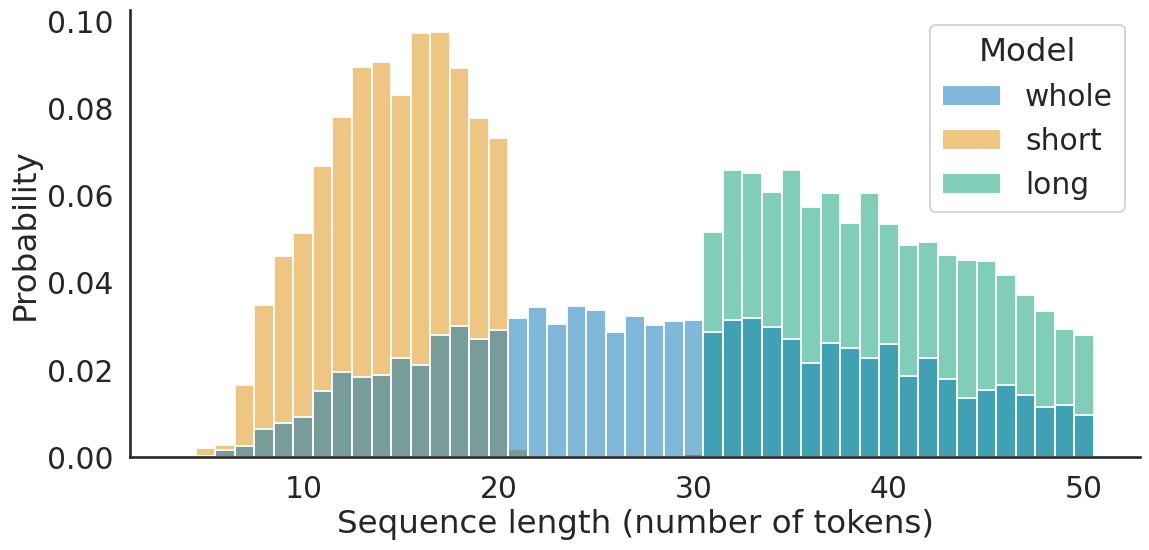

In [0]:
# @title `lm1b-synthetic-annotators.pdf`
eos_id = LM1B_CONFIG.model.eos_id

with custom_theme(font_scale=1.3):
  _, ax = plt.subplots(figsize=(12, 6))
  _ = sns.histplot(
      pd.concat(
          [
              pd.DataFrame({
                  'Sequence length (number of tokens)': (
                      np.argmax(
                          LM1B_CONFIG.samples[model_name] == eos_id, axis=-1
                      ).astype(np.int32)
                      + 1
                  ),
                  'Model': model_name,
              })
              for model_name in ('whole', 'short', 'long')
          ]
      ),
      x='Sequence length (number of tokens)',
      hue='Model',
      stat='probability',
      multiple='layer',
      discrete=True,
      common_norm=False,
      ax=ax,
  )
  plt.tight_layout()
  plt.savefig('lm1b-synthetic-annotators.pdf')
  plt.show()

**Sequence lengths (model checkpoints)**: Histogram of sequence lengths for sequences sampled from the *whole*, *short*, and *long* model checkpoints.

## Annotator preference acquisition

In [0]:
# @title Higher-order function for sampling from the LM1B model checkpoints
def make_preference_sampling_loop_fn(
    model: nn.Module, batch_size: int
) -> Callable[
    [jax.Array, VariableDict, jnp.ndarray, jnp.ndarray, jnp.ndarray | None],
    jnp.ndarray,
]:
  """Creates a preference sampling loop function.

  The function accepts the following as input:

  * key: The PRNG key used to draw samples.
  * params: Either a VariableDict or a list of VariableDict for the parameters
      of the model(s). If there are more than one set of model parameters, the
      Luce choice rule is computed from a model mixture using `mixture_weights`.
      Parameters are expected to be *unreplicated*: the preference sampling
      function handles the task of replicating model parameters as needed to
      accommodate the accelerator architecture.
  * tokens_a: The *unsharded* array of "A" tokens. Can be arbitrarily large: the
      preference sampling function automatically samples preferences batches of
      a size dictated by `PER_DEVICE_BATCH_SIZE`.
  * tokens_b: The *unsharded* array of "B" tokens. Should have the same length
      as `tokens_a`.
  * mixture_logits: The mixture logits. If None, the logits are set zero (i.e.,
      a uniform distribution across models.

  Args:
    model: The flax module representing the language model.
    batch_size: The batch size for each step of the preference sampling loop.

  Returns:
    The preference sampling loop function.
  """

  @functools.partial(jax.pmap, axis_name='batch')
  def _preference_step(key, params, tokens_a, tokens_b, mixture_logits):
    log_p_a = nn.logsumexp(
        jnp.stack([model.apply({'params': p}, tokens_a) for p in params])
        + nn.log_softmax(mixture_logits)[:, None],
        axis=0,
    )
    log_p_b = nn.logsumexp(
        jnp.stack([model.apply({'params': p}, tokens_b) for p in params])
        + nn.log_softmax(mixture_logits)[:, None],
        axis=0,
    )
    logits = model.max_length * (
        log_p_a / (tokens_a > 0).sum(axis=-1)
        - log_p_b / (tokens_b > 0).sum(axis=-1)
    )
    return tfd.Bernoulli(logits=logits).sample(seed=key)

  def preference_sampling_loop(
      key, params, tokens_a, tokens_b, mixture_logits=None
  ):
    if not isinstance(params, Sequence):
      params = [params]

    num_annotators = len(params)
    mixture_logits = (
        jnp.zeros((num_annotators,))
        if mixture_logits is None
        else mixture_logits
    )

    params = flax.jax_utils.replicate(params)
    mixture_logits = flax.jax_utils.replicate(mixture_logits)

    num_batches = int(np.ceil(tokens_a.shape[0] / batch_size))

    y = []

    for i, (t_a, t_b) in tqdm.notebook.tqdm(
        enumerate(
            zip(
                jnp.array_split(tokens_a, num_batches),
                jnp.array_split(tokens_b, num_batches),
            )
        ),
        total=num_batches,
    ):
      if t_a.shape[0] % batch_size:
        t_a, t_b = jax.tree_util.tree_map(
            lambda x: pad_examples(x, batch_size), (t_a, t_b)
        )
      y.append(
          _preference_step(
              jax.random.split(
                  jax.random.fold_in(key, i), jax.local_device_count()
              ),
              params,
              common_utils.shard(t_a),
              common_utils.shard(t_b),
              mixture_logits,
          ).reshape(-1)
      )

    return jnp.concatenate(y)[: tokens_a.shape[0]]

  return preference_sampling_loop

In [0]:
preference_sampling_loop = make_preference_sampling_loop_fn(
    LM1B_CONFIG.model, LM1B_CONFIG.training.batch_size
)

for model_name in ('short', 'long'):
  print(
      f'Sampling preferences using the "{model_name}" implicit preference '
      'distribution...'
  )
  LM1B_CONFIG.training.data[f'y_{model_name}'] = preference_sampling_loop(
      fold_in_str(LM1B_CONFIG.random.key, f'{model_name}_preferences'),
      LM1B_CONFIG.states[model_name].params,
      LM1B_CONFIG.training.data.tokens_a,
      LM1B_CONFIG.training.data.tokens_b,
  )

print(
    'Sampling preferences using a "short + long mixture" implicit preference '
    'distribution...'
)
p_annotator_1 = LM1B_CONFIG.training.p_annotator_1
LM1B_CONFIG.training.data['y_mixture_annotator'] = preference_sampling_loop(
    fold_in_str(LM1B_CONFIG.random.key, 'mixture_preferences'),
    [LM1B_CONFIG.states['short'].params, LM1B_CONFIG.states['long'].params],
    LM1B_CONFIG.training.data.tokens_a,
    LM1B_CONFIG.training.data.tokens_b,
    jnp.array([p_annotator_1, 1.0 - p_annotator_1]),
)

print(
    'Building the "annotator mixture" preference dataset from the "short" and '
    '"long" preference datasets...'
)
annotator_partition = jax.random.choice(
    key=fold_in_str(LM1B_CONFIG.random.key, 'preference_partition'),
    a=2,
    shape=(LM1B_CONFIG.training.data.tokens_a.shape[0],),
    replace=True,
    p=jnp.array([p_annotator_1, 1.0 - p_annotator_1]),
)
LM1B_CONFIG.training.data['y_multi_annotator'] = jnp.stack(
    [LM1B_CONFIG.training.data['y_short'], LM1B_CONFIG.training.data['y_long']]
)[
    annotator_partition,
    jnp.arange(LM1B_CONFIG.training.data.tokens_a.shape[0], dtype=jnp.int32),
]

## Training

In [0]:
# @title Higher-order function for the LM1B training step
def make_lm1b_train_step_fn(
    model: nn.Module, beta: float | None, axis_name: str | None = None
) -> Callable[
    [TrainState, TrainState, jnp.ndarray, jnp.ndarray, jnp.ndarray], TrainState
]:
  """Creates a training step function.

  The function accepts the following as input:

  * state: The model state.
  * tokens_a: The batch of "A" tokens.
  * tokens_b: The  of "B" tokens. Should have the same length as
      `tokens_a`.
  * y: The batch of binary preference outcomes. Should have the same length as
      `tokens_a`.

  Args:
    model: The flax module representing the language model.
    beta: The KL-divergence coefficient. If None, no KL-control is applied.
    axis_name: The name of the axis over which to apply the `pmean` operation on
      the gradients. If None, no `pmean` will be applied.

  Returns:
    The training step function.
  """

  def loss(params, tokens_a, tokens_b, y):
    apply_method = model.preference_logits
    logits = model.apply(
        {'params': params}, tokens_a, tokens_b, method=apply_method
    )
    loss = -tfd.Bernoulli(logits=logits).log_prob(y)
    if beta is not None:
      loss -= beta * (
          model.apply({'params': params}, tokens_a)
          + model.apply({'params': params}, tokens_b)
      )
    return loss.mean()

  def train_step(state, tokens_a, tokens_b, y):
    grads = jax.grad(loss)(state.params, tokens_a, tokens_b, y)
    if axis_name:
      grads = jax.lax.pmean(grads, axis_name='batch')
    return state.apply_gradients(grads=grads)

  return train_step

In [0]:
y_multi_annotator = LM1B_CONFIG.training.data.y_multi_annotator
y_mixture_annotator = LM1B_CONFIG.training.data.y_mixture_annotator

lm1b_states = {}
for dataset_name, y in zip(
    ('Annotator mixture', 'Density mixture'),
    (y_multi_annotator, y_mixture_annotator),
):
  # PRNG
  key = fold_in_str(LM1B_CONFIG.random.key, f'LM1B {dataset_name} training')

  # Optimizer
  optimizer = optax.adam(LM1B_CONFIG.training.learning_rate)

  # Model
  model = LM1B_CONFIG.model
  apply_fn = functools.partial(model.apply, method=model.preference_logits)
  params = LM1B_CONFIG.states['whole'].params
  state = flax.jax_utils.replicate(
      TrainState.create(apply_fn=apply_fn, params=params, tx=optimizer)
  )

  # Inputs
  tokens_a = LM1B_CONFIG.training.data.tokens_a
  tokens_b = LM1B_CONFIG.training.data.tokens_b
  num_batches = int(
      np.ceil(tokens_a.shape[0] / LM1B_CONFIG.training.batch_size)
  )

  def _shuffle_dataset(epoch):
    permutation = jax.random.permutation(
        jax.random.fold_in(key, epoch), y.shape[0]
    )
    return tokens_a[permutation], tokens_b[permutation], y[permutation]

  # Optimization loop
  print(f'Training on the {dataset_name.lower()} dataset...')

  beta = LM1B_CONFIG.training.beta
  pmapped_train_step = jax.pmap(
      make_lm1b_train_step_fn(model, beta),
      axis_name='batch',
  )

  epoch_counter = itertools.count(1)
  step_counter = itertools.count(1)
  done = False

  with tqdm.notebook.tqdm(total=LM1B_CONFIG.training.num_steps) as progress_bar:
    while not done:
      shuffled_tokens_a, shuffled_tokens_b, shuffled_y = _shuffle_dataset(
          next(epoch_counter)
      )
      for t_a, t_b, y_ in zip(
          jnp.array_split(shuffled_tokens_a, num_batches),
          jnp.array_split(shuffled_tokens_b, num_batches),
          jnp.array_split(shuffled_y, num_batches),
      ):
        # Skip remainder batch.
        if t_a.shape[0] % LM1B_CONFIG.training.batch_size:
          continue

        state = pmapped_train_step(
            state,
            common_utils.shard(t_a),
            common_utils.shard(t_b),
            common_utils.shard(y_),
        )

        step = next(step_counter)
        done = step == LM1B_CONFIG.training.num_steps
        progress_bar.update(1)

        if done:
          break

  lm1b_states[dataset_name] = flax.jax_utils.unreplicate(state)

In [0]:
# @title Sample from the adapted models
lm1b_tokens = {}
for dataset_name, state in lm1b_states.items():
  print(
      f'Sampling from the model trained on the "{dataset_name}" preference '
      'dataset...'
  )
  lm1b_tokens[dataset_name] = sampling_loop(
      fold_in_str(
          LM1B_CONFIG.random.key, f'adapted_{dataset_name}_sample_tokens'
      ),
      state.params,
      LM1B_CONFIG.training.num_model_samples,
  )

In [0]:
# @title Print samples
eos_id = LM1B_CONFIG.model.eos_id

for dataset_name, tokens in lm1b_tokens.items():
  print(
      f'adapted ({dataset_name}):\n\t'
      + '\n\t'.join(
          decode_tokens(LM1B_CONFIG.tokenizer, s, eos_id) for s in tokens[:8]
      )
  )

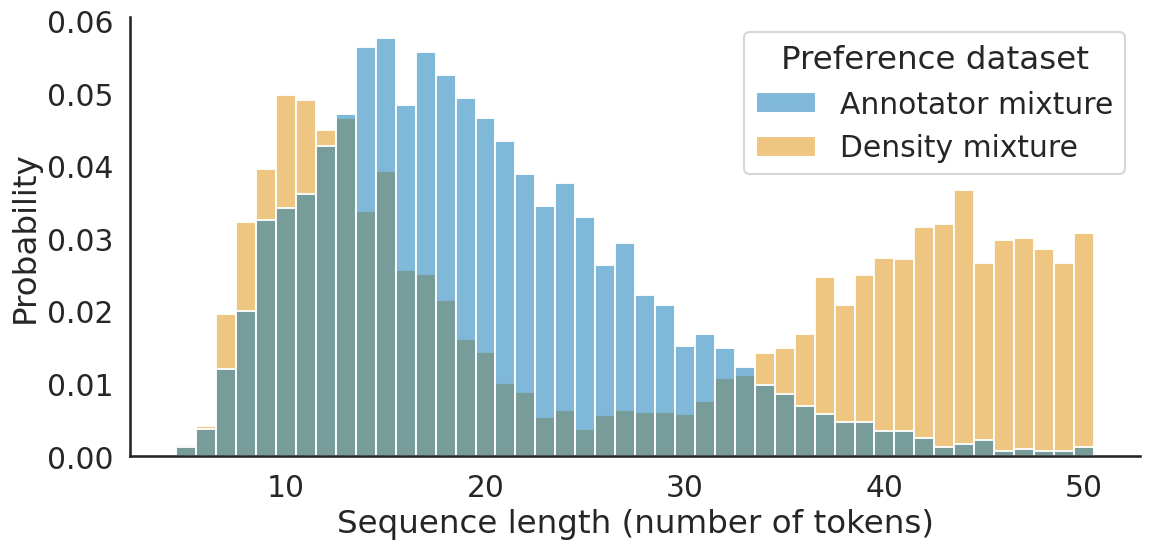

In [0]:
# @title `lm1b-mixture-types.pdf`
eos_id = LM1B_CONFIG.model.eos_id

with custom_theme(font_scale=1.3):
  _, ax = plt.subplots(figsize=(12, 6))
  _ = sns.histplot(
      pd.concat(
          [
              pd.DataFrame({
                  'Sequence length (number of tokens)': (
                      np.argmax(tokens == eos_id, axis=-1).astype(np.int32) + 1
                  ),
                  'Preference dataset': dataset_name,
              })
              for dataset_name, tokens in lm1b_tokens.items()
          ]
      ),
      x='Sequence length (number of tokens)',
      hue='Preference dataset',
      stat='probability',
      multiple='layer',
      discrete=True,
      common_norm=False,
      ax=ax,
  )
  plt.tight_layout()
  plt.savefig('lm1b-mixture-types.pdf')
  plt.show()

**Sequence lengths (trained models)**: Histogram of sequence lengths after adapting the pretrained model $\pi_\mathrm{pre}(x)$ (the *whole* model checkpoint) on two distinct preference datasets: the "annotator mixture" dataset and the "density mixture" dataset.